## Filter Data only containing composite images and preprocessed the data

In [8]:
import pandas as pd
import numpy as np
import os

def merge_crime_data_with_composite_stations_clean():
    """
    Merge crime data with composite stations - NO _x/_y suffixes
    Handle overlapping columns BEFORE merge to avoid duplicates
    """
    print("=" * 80)
    print("CLEAN MERGE: CRIME DATA + COMPOSITE STATIONS (NO SUFFIXES)")
    print("=" * 80)
    
    # Load datasets
    df_composite_stations = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\composite_properties_with_Rightmove.csv')
    df_crime_data = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\composite_crime_rates_FINAL_ALL_PROPERTIES.csv')
    
    print(f"Composite stations dataset: {len(df_composite_stations)} properties")
    print(f"Crime data dataset: {len(df_crime_data)} properties")
    
    # VERIFY BOTH DATASETS HAVE 'title' COLUMN
    print(f"\n🔍 VERIFYING JOIN COLUMNS:")
    print(f"'title' in composite dataset: {'title' in df_composite_stations.columns}")
    print(f"'title' in crime dataset: {'title' in df_crime_data.columns}")
    
    if 'title' not in df_composite_stations.columns:
        print("❌ ERROR: 'title' column missing from composite dataset!")
        print(f"Available columns: {list(df_composite_stations.columns)}")
        return None
        
    if 'title' not in df_crime_data.columns:
        print("❌ ERROR: 'title' column missing from crime dataset!")
        print(f"Available columns: {list(df_crime_data.columns)}")
        return None
    
    # Identify overlapping columns
    composite_cols = set(df_composite_stations.columns)
    crime_cols = set(df_crime_data.columns)
    overlapping_cols = composite_cols & crime_cols
    
    print(f"\n🔍 OVERLAPPING COLUMNS TO RESOLVE:")
    for col in sorted(overlapping_cols):
        print(f"  - {col}")
    
    # STRATEGY: Keep composite versions, add only unique crime columns
    
    # 1. SELECT COLUMNS FROM COMPOSITE (our primary dataset)
    composite_keep_cols = [
        'title', 'bedrooms', 'bathrooms', 'size_sqft', 'price',
        'parking', 'garden', 'council_tax', 'latitude', 'longitude',
        'station_distances', 'nearest_stations', 'postcode','description', 'property_type', 'tenure_type'
    ]
    
    
    # Filter available columns from composite
    available_composite_cols = [col for col in composite_keep_cols 
                               if col in df_composite_stations.columns]
    
    print(f"\n📋 KEEPING FROM COMPOSITE ({len(available_composite_cols)} columns):")
    for col in available_composite_cols:
        print(f"  - {col}")
    
    # 2. SELECT ONLY UNIQUE CRIME COLUMNS (no overlaps)
    crime_unique_cols = ['title']  # Join key
    
    # Add all crime-specific columns that DON'T overlap with composite
    for col in df_crime_data.columns:
        if col not in overlapping_cols and col != 'title':
            # Only add crime-related columns
            if any(keyword in col.lower() for keyword in ['crime', 'annual_', 'total_']):
                crime_unique_cols.append(col)
    
    print(f"\n📋 ADDING UNIQUE CRIME COLUMNS ({len(crime_unique_cols)-1} columns):")
    for col in crime_unique_cols[1:15]:  # Show first 14 (skip 'title')
        print(f"  - {col}")
    if len(crime_unique_cols) > 15:
        print(f"  ... and {len(crime_unique_cols) - 15} more")
    
    # 3. PREPARE CLEAN DATASETS FOR MERGE
    print(f"\n🔗 PREPARING DATASETS FOR MERGE...")
    df_composite_clean = df_composite_stations[available_composite_cols].copy()
    df_crime_clean = df_crime_data[crime_unique_cols].copy()
    
    print(f"Composite columns selected: {df_composite_clean.columns.tolist()}")
    print(f"Crime columns selected: {df_crime_clean.columns.tolist()}")
    
    # Remove duplicates from crime data
    df_crime_clean = df_crime_clean.drop_duplicates(subset=['title'])
    
    print(f"\nComposite dataset: {len(df_composite_clean)} properties, {len(df_composite_clean.columns)} columns")
    print(f"Crime dataset: {len(df_crime_clean)} unique properties, {len(df_crime_clean.columns)} columns")
    
    # 4. MERGE WITH NO OVERLAPPING COLUMNS = NO SUFFIXES!
    df_final = pd.merge(
        df_composite_clean, 
        df_crime_clean, 
        on='title', 
        how='left'
        # No suffixes parameter needed - no overlapping columns!
    )
    
    print(f"✅ Clean merge completed: {len(df_final)} properties")
    print(f"Total columns: {len(df_final.columns)}")
    
    # 5. VERIFY NO SUFFIXES EXIST
    x_cols = [col for col in df_final.columns if col.endswith('_x')]
    y_cols = [col for col in df_final.columns if col.endswith('_y')]
    
    print(f"\n✅ SUFFIX VERIFICATION:")
    print(f"Columns with _x suffix: {len(x_cols)} {x_cols}")
    print(f"Columns with _y suffix: {len(y_cols)} {y_cols}")
    
    if len(x_cols) == 0 and len(y_cols) == 0:
        print("🎉 SUCCESS: No duplicate suffixes found!")
    else:
        print("⚠️ WARNING: Unexpected suffixes detected")
    
    # 6. CHECK MERGE SUCCESS
    crime_data_cols = [col for col in df_final.columns if 'crime' in col.lower()]
    if crime_data_cols:
        first_crime_col = crime_data_cols[0]
        properties_with_crime = df_final[first_crime_col].notna().sum()
        print(f"\n📊 MERGE SUCCESS:")
        print(f"Properties with crime data: {properties_with_crime}/{len(df_final)}")
        print(f"Crime data coverage: {(properties_with_crime/len(df_final)*100):.1f}%")
    
    # 7. SAVE CLEAN DATASET
    output_file = r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_CLEAN.csv'
    df_final.to_csv(output_file, index=False)
    
    print(f"\n✅ CLEAN DATASET SAVED!")
    print(f"📁 File: {output_file}")
    print(f"🏠 Properties: {len(df_final):,}")
    print(f"📊 Features: {len(df_final.columns)}")
    print(f"🧹 Zero duplicate columns with _x/_y suffixes!")
    
    return df_final

# Execute the completely clean merge
print("🚀 Starting CLEAN merge with NO suffixes...")
df_final_clean = merge_crime_data_with_composite_stations_clean()

if df_final_clean is not None:
    print(f"\n🎉 CLEAN MERGE COMPLETE!")
    print(f"✅ Zero _x/_y suffixes")
    print(f"✅ All composite housing data preserved")
    print(f"✅ All unique crime data added")
    print(f"✅ Ready for analysis and modeling!")
    
    # Verify the clean result
    print(f"\n🔍 FINAL VERIFICATION:")
    all_cols = list(df_final_clean.columns)
    suffix_cols = [col for col in all_cols if any(suffix in col for suffix in ['_x', '_y'])]
    print(f"Total columns: {len(all_cols)}")
    print(f"Columns with suffixes: {len(suffix_cols)} {suffix_cols}")
    print(f"✅ SUCCESS: Clean dataset with no duplicate suffixes!")

🚀 Starting CLEAN merge with NO suffixes...
CLEAN MERGE: CRIME DATA + COMPOSITE STATIONS (NO SUFFIXES)
Composite stations dataset: 41835 properties
Crime data dataset: 41835 properties

🔍 VERIFYING JOIN COLUMNS:
'title' in composite dataset: True
'title' in crime dataset: True

🔍 OVERLAPPING COLUMNS TO RESOLVE:
  - latitude
  - longitude
  - title

📋 KEEPING FROM COMPOSITE (16 columns):
  - title
  - bedrooms
  - bathrooms
  - size_sqft
  - price
  - parking
  - garden
  - council_tax
  - latitude
  - longitude
  - station_distances
  - nearest_stations
  - postcode
  - description
  - property_type
  - tenure_type

📋 ADDING UNIQUE CRIME COLUMNS (28 columns):
  - annual_total_crimes
  - average_monthly_crimes
  - annual_crime_anti_social_behaviour
  - annual_crime_bicycle_theft
  - annual_crime_burglary
  - annual_crime_criminal_damage_arson
  - annual_crime_drugs
  - annual_crime_other_theft
  - annual_crime_possession_of_weapons
  - annual_crime_public_order
  - annual_crime_robbery
 

In [ ]:
import pandas as pd
import numpy as np

def smart_replace_zero_bedrooms_bathrooms(df_clean):
    """
    Replace ONLY the 0 bedrooms/bathrooms with realistic estimates using property type
    Keep all existing non-zero data unchanged
    """
    print("=" * 60)
    print("SMART REPLACEMENT OF ZERO BEDROOMS/BATHROOMS ONLY")
    print("=" * 60)
    
    # Check current distribution
    print(f"Current bedroom distribution:")
    print(df_clean['bedrooms'].value_counts().sort_index())
    print(f"\nCurrent bathroom distribution:")
    print(df_clean['bathrooms'].value_counts().sort_index())
    
    # Count zeros to replace
    zero_bedrooms = (df_clean['bedrooms'] == 0).sum()
    zero_bathrooms = (df_clean['bathrooms'] == 0).sum()
    
    print(f"\n🎯 TARGETING REPLACEMENTS:")
    print(f"Properties with 0 bedrooms (weird): {zero_bedrooms}")
    print(f"Properties with 0 bathrooms (weird): {zero_bathrooms}")
    
    # Define realistic estimates by property type
    typical_bedrooms = {
        'Apartment': 1, 'Flat': 1, 'Studio': 1,  # Studio can be 1 for this purpose
        'Block of Apartments': 1, 'Duplex': 2, 'Maisonette': 2, 'Penthouse': 2,
        'House': 3, 'Detached': 4, 'Villa': 4, 'Link Detached House': 3, 'Bungalow': 2,
        'Semi-Detached': 3,
        'End of Terrace': 2, 'Terraced': 2, 'Town House': 3, 'Mews': 2,
        'Retirement Property': 1, 'Other': 2
    }
    
    typical_bathrooms = {
        'Apartment': 1, 'Flat': 1, 'Studio': 1,
        'Block of Apartments': 1, 'Duplex': 2, 'Maisonette': 1, 'Penthouse': 2,
        'House': 2, 'Detached': 3, 'Villa': 3, 'Link Detached House': 2, 'Bungalow': 2,
        'Semi-Detached': 2,
        'End of Terrace': 1, 'Terraced': 1, 'Town House': 2, 'Mews': 1,
        'Retirement Property': 1, 'Other': 1
    }
    
    # REPLACE ONLY ZERO BEDROOMS
    if zero_bedrooms > 0:
        print(f"\n🏠 REPLACING {zero_bedrooms} ZERO BEDROOMS:")
        
        # Method 1: Use property type for zeros
        if 'property_type' in df_clean.columns:
            for prop_type, typical_bed in typical_bedrooms.items():
                # Only target properties with 0 bedrooms
                mask = (df_clean['property_type'] == prop_type) & (df_clean['bedrooms'] == 0)
                count = mask.sum()
                if count > 0:
                    df_clean.loc[mask, 'bedrooms'] = typical_bed
                    print(f"  Replaced {count} {prop_type} properties: 0 → {typical_bed} bedrooms")
        
        # Method 2: Fallback for remaining zeros
        remaining_zeros = (df_clean['bedrooms'] == 0).sum()
        if remaining_zeros > 0:
            # Use median of non-zero bedrooms
            non_zero_median = df_clean[df_clean['bedrooms'] > 0]['bedrooms'].median()
            df_clean.loc[df_clean['bedrooms'] == 0, 'bedrooms'] = non_zero_median
            print(f"  Replaced remaining {remaining_zeros} zeros with median: {non_zero_median} bedrooms")
    
    # REPLACE ONLY ZERO BATHROOMS
    if zero_bathrooms > 0:
        print(f"\n🛁 REPLACING {zero_bathrooms} ZERO BATHROOMS:")
        
        # Method 1: Use property type for zeros
        if 'property_type' in df_clean.columns:
            for prop_type, typical_bath in typical_bathrooms.items():
                # Only target properties with 0 bathrooms
                mask = (df_clean['property_type'] == prop_type) & (df_clean['bathrooms'] == 0)
                count = mask.sum()
                if count > 0:
                    df_clean.loc[mask, 'bathrooms'] = typical_bath
                    print(f"  Replaced {count} {prop_type} properties: 0 → {typical_bath} bathrooms")
        
        # Method 2: Fallback for remaining zeros
        remaining_zeros = (df_clean['bathrooms'] == 0).sum()
        if remaining_zeros > 0:
            # Use median of non-zero bathrooms
            non_zero_median = df_clean[df_clean['bathrooms'] > 0]['bathrooms'].median()
            df_clean.loc[df_clean['bathrooms'] == 0, 'bathrooms'] = non_zero_median
            print(f"  Replaced remaining {remaining_zeros} zeros with median: {non_zero_median} bathrooms")
    
    # VERIFY NO MORE ZEROS
    print(f"\n✅ VERIFICATION:")
    final_zero_bed = (df_clean['bedrooms'] == 0).sum()
    final_zero_bath = (df_clean['bathrooms'] == 0).sum()
    print(f"Properties with 0 bedrooms after fix: {final_zero_bed}")
    print(f"Properties with 0 bathrooms after fix: {final_zero_bath}")
    
    # Show new distributions
    print(f"\n📊 NEW DISTRIBUTIONS:")
    print(f"Bedrooms: {df_clean['bedrooms'].value_counts().sort_index().to_dict()}")
    print(f"Bathrooms: {df_clean['bathrooms'].value_counts().sort_index().to_dict()}")
    
    return df_clean

def preprocess_housing_data_complete(remove_council_tax=False):
    """
    COMPLETE: Housing data preprocessing including property type and tenure type processing
    """
    print("=" * 60)
    print("🚀 COMPLETE HOUSING DATA PREPROCESSING")
    print("=" * 60)
    
    # Load data
    df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_CLEAN.csv')
    print(f"Loaded: {df.shape}")
    
    # 1. BASIC PREPROCESSING (Price, Parking, Garden)
    print(f"\n🔧 BASIC PREPROCESSING...")
    df['price'] = pd.to_numeric(df['price'].astype(str).str.replace('£|,', '', regex=True), errors='coerce')
    
    binary_maps = {
        'parking': {'yes': 1, 'allocated': 1, 'no': 0, 'ask agent': 0, 'nan': 0},
        'garden': {'yes': 1, 'private garden': 1, 'no': 0, 'ask agent': 0, 'nan': 0}
    }
    for col, mapping in binary_maps.items():
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().map(mapping).fillna(0)
    
    # 2. COUNCIL TAX
    if 'council_tax' in df.columns:
        if remove_council_tax:
            df = df.drop('council_tax', axis=1)
            print("Removed council_tax")
        else:
            ct_map = {f'band: {band}': i for i, band in enumerate(['a','b','c','d','e','f','g','h','i'], 1)}
            ct_map.update({'band: tbc': 0, 'ask agent': 0, 'ask developer': 0, 'nan': 0})
            df['council_tax'] = df['council_tax'].astype(str).str.lower().map(ct_map).fillna(0)
    
    # 3. SMART ZERO REPLACEMENT USING PROPERTY TYPE
    print(f"\n🎯 APPLYING SMART ZERO REPLACEMENT...")
    df = smart_replace_zero_bedrooms_bathrooms(df)
    
    # 4. PROPERTY TYPE PROCESSING (FIXED!)
    print(f"\n🏠 PREPROCESSING PROPERTY TYPE...")
    property_mapping = {
        'Apartment': 'F', 'Flat': 'F', 'Studio': 'F', 'Block of Apartments': 'F', 
        'Duplex': 'F', 'Maisonette': 'F', 'Penthouse': 'F',
        'House': 'D', 'Detached': 'D', 'Villa': 'D', 'Link Detached House': 'D', 'Bungalow': 'D',
        'Semi-Detached': 'S',
        'End of Terrace': 'T', 'Terraced': 'T', 'Town House': 'T', 'Mews': 'T',
        'Retirement Property': 'O', 'Equestrian Facility': 'O', 'Land': 'O', 'Not Specified': 'O'
    }
    
    if 'property_type' in df.columns:
        print(f"Original property types: {df['property_type'].value_counts().to_dict()}")
        df['property_type_mapped'] = df['property_type'].map(property_mapping).fillna('O')
        
        # Create property dummies
        property_dummies = pd.get_dummies(df['property_type_mapped'], prefix='property')
        df = pd.concat([df, property_dummies], axis=1)
        print(f"Property dummies created: {[col for col in df.columns if col.startswith('property_')]}")
    else:
        print("⚠️ property_type column not found")
    
    # 5. TENURE TYPE PROCESSING (ADDED!)
    print(f"\n📋 PREPROCESSING TENURE TYPE...")
    if 'tenure_type' in df.columns:
        print(f"Original tenure types: {df['tenure_type'].value_counts().to_dict()}")
        df['tenure_type'] = df['tenure_type'].fillna('Unknown')
        
        # Create tenure dummies
        tenure_dummies = pd.get_dummies(df['tenure_type'], prefix='tenure')
        df = pd.concat([df, tenure_dummies], axis=1)
        print(f"Tenure dummies created: {[col for col in df.columns if col.startswith('tenure_')]}")
    else:
        print("⚠️ tenure_type column not found")
    
    # 6. STATION FEATURES (FIXED!)
    print(f"\n🚂 STATION FEATURES...")
    def extract_station_data(row):
        try:
            # Extract minimum distance
            if 'station_distances' in df.columns and pd.notna(row['station_distances']):
                distances_str = str(row['station_distances'])
                distance_parts = distances_str.split(';')
                distances = []
                for part in distance_parts:
                    clean_part = part.strip().replace(' miles', '').replace('miles', '')
                    try:
                        distances.append(float(clean_part))
                    except:
                        continue
                min_distance = min(distances) if distances else 1.0
                station_count = len(distances)
            else:
                min_distance = 1.0
                station_count = 1
            
            # Extract first station name
            if 'nearest_stations' in df.columns and pd.notna(row['nearest_stations']):
                stations_str = str(row['nearest_stations'])
                station_parts = stations_str.split(';')
                first_station = station_parts[0].strip() if station_parts else 'Unknown'
            else:
                first_station = 'Unknown'
            
            return pd.Series({
                'min_station_distance': min_distance,
                'nearest_station_name': first_station,
                'nearby_stations_count': station_count
            })
        except:
            return pd.Series({
                'min_station_distance': 1.0,
                'nearest_station_name': 'Unknown',
                'nearby_stations_count': 0
            })
    
    if 'station_distances' in df.columns and 'nearest_stations' in df.columns:
        station_features = df.apply(extract_station_data, axis=1)
        df[['min_station_distance', 'nearest_station_name', 'nearby_stations_count']] = station_features
        print(f"✅ Extracted station features")
        print(f"Distance range: {df['min_station_distance'].min():.3f} - {df['min_station_distance'].max():.3f}")
    else:
        df['min_station_distance'] = 1.0
        df['nearest_station_name'] = 'Unknown'
        df['nearby_stations_count'] = 0
        print("⚠️ Station columns not found - used defaults")
    
    # 7. FINAL CLEANUP
    print(f"\n🔧 CLEANUP...")
    # Fill missing values
    numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 'latitude', 'longitude', 
                   'min_station_distance', 'nearby_stations_count']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Convert dummies to int
    dummy_cols = [col for col in df.columns if col.startswith(('property_', 'tenure_'))]
    for col in dummy_cols:
        df[col] = df[col].astype(int)
        
    print(f"Converted {len(dummy_cols)} dummy columns to int")
    
    # 8. SAVE
    suffix = "_NO_COUNCIL_TAX" if remove_council_tax else "_SIMPLIFIED"
    output_file = rf'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime{suffix}.csv'
    df.to_csv(output_file, index=False)
    
    print(f"\n✅ COMPLETE!")
    print(f"📁 Saved: {output_file}")
    print(f"📊 Shape: {df.shape}")
    print(f"🏠 Zero bedrooms: {(df['bedrooms'] == 0).sum()}")
    print(f"🛁 Zero bathrooms: {(df['bathrooms'] == 0).sum()}")
    print(f"🚂 Station features: min_distance, station_name, station_count")
    
    # Show sample
    sample_cols = ['price', 'bedrooms', 'bathrooms', 'parking', 'garden', 
                   'min_station_distance', 'nearest_station_name']
    if 'council_tax' in df.columns:
        sample_cols.append('council_tax')
    
    # Add property and tenure dummies to sample
    property_cols = [col for col in df.columns if col.startswith('property_')][:3]
    tenure_cols = [col for col in df.columns if col.startswith('tenure_')][:3]
    sample_cols.extend(property_cols + tenure_cols)
    
    available_cols = [col for col in sample_cols if col in df.columns]
    print(f"\n📊 SAMPLE:")
    print(df[available_cols].head())
    
    # Summary of created features
    property_dummies = [col for col in df.columns if col.startswith('property_')]
    tenure_dummies = [col for col in df.columns if col.startswith('tenure_')]
    
    print(f"\n📋 FEATURE SUMMARY:")
    print(f"Property dummies created: {len(property_dummies)} -> {property_dummies}")
    print(f"Tenure dummies created: {len(tenure_dummies)} -> {tenure_dummies}")
    
    return df

# Execute complete preprocessing
print("🚀 Starting COMPLETE preprocessing with property type and tenure type...")

try:
    df_final = preprocess_housing_data_complete(remove_council_tax=False)
    print(f"\n🎉 SUCCESS WITH COUNCIL TAX!")
    
    # Check council tax quality
    if 'council_tax' in df_final.columns:
        unknown_pct = (df_final['council_tax'] == 0).sum() / len(df_final) * 100
        print(f"📊 Council tax unknown: {unknown_pct:.1f}%")
        
        if unknown_pct > 50:
            print(f"⚠️ High unknown percentage - creating version without council tax...")
            df_no_ct = preprocess_housing_data_complete(remove_council_tax=True)
            print(f"📊 TWO VERSIONS SAVED:")
            print(f"  1. WITH council tax: housing_composite_crime_SIMPLIFIED.csv")
            print(f"  2. WITHOUT council tax: housing_composite_crime_NO_COUNCIL_TAX.csv")
    
    # Verify property and tenure processing
    property_cols = [col for col in df_final.columns if col.startswith('property_')]
    tenure_cols = [col for col in df_final.columns if col.startswith('tenure_')]
    
    print(f"\n🔍 VERIFICATION:")
    print(f"✅ Property type dummies: {len(property_cols)} columns")
    print(f"✅ Tenure type dummies: {len(tenure_cols)} columns")
    print(f"✅ All categorical variables properly encoded as dummies")

except Exception as e:
    print(f"❌ Error: {e}")
    print(f"🔄 Trying without council tax...")
    df_final = preprocess_housing_data_complete(remove_council_tax=True)

print(f"\n✅ COMPLETE PREPROCESSING FINISHED!")
print(f"🎯 All features properly processed including:")
print(f"   ✅ Smart zero replacement using property types")
print(f"   ✅ Property type dummy encoding")
print(f"   ✅ Tenure type dummy encoding") 
print(f"   ✅ Fixed station feature extraction")
print(f"   ✅ Complete data preprocessing pipeline")

SyntaxError: '(' was never closed (74739841.py, line 227)

In [13]:
import pandas as pd
import numpy as np

def smart_replace_zero_bedrooms_bathrooms(df_clean):
    """
    Replace ONLY the 0 bedrooms/bathrooms with realistic estimates using property type
    Keep all existing non-zero data unchanged
    """
    print("=" * 60)
    print("SMART REPLACEMENT OF ZERO BEDROOMS/BATHROOMS ONLY")
    print("=" * 60)
    
    # Check current distribution
    print(f"Current bedroom distribution:")
    print(df_clean['bedrooms'].value_counts().sort_index())
    print(f"\nCurrent bathroom distribution:")
    print(df_clean['bathrooms'].value_counts().sort_index())
    
    # Count zeros to replace
    zero_bedrooms = (df_clean['bedrooms'] == 0).sum()
    zero_bathrooms = (df_clean['bathrooms'] == 0).sum()
    
    print(f"\n🎯 TARGETING REPLACEMENTS:")
    print(f"Properties with 0 bedrooms (weird): {zero_bedrooms}")
    print(f"Properties with 0 bathrooms (weird): {zero_bathrooms}")
    
    # Define realistic estimates by property type
    typical_bedrooms = {
        'Apartment': 1, 'Flat': 1, 'Studio': 1,  # Studio can be 1 for this purpose
        'Block of Apartments': 1, 'Duplex': 2, 'Maisonette': 2, 'Penthouse': 2,
        'House': 3, 'Detached': 4, 'Villa': 4, 'Link Detached House': 3, 'Bungalow': 2,
        'Semi-Detached': 3,
        'End of Terrace': 2, 'Terraced': 2, 'Town House': 3, 'Mews': 2,
        'Retirement Property': 1, 'Other': 2
    }
    
    typical_bathrooms = {
        'Apartment': 1, 'Flat': 1, 'Studio': 1,
        'Block of Apartments': 1, 'Duplex': 2, 'Maisonette': 1, 'Penthouse': 2,
        'House': 2, 'Detached': 3, 'Villa': 3, 'Link Detached House': 2, 'Bungalow': 2,
        'Semi-Detached': 2,
        'End of Terrace': 1, 'Terraced': 1, 'Town House': 2, 'Mews': 1,
        'Retirement Property': 1, 'Other': 1
    }
    
    # REPLACE ONLY ZERO BEDROOMS
    if zero_bedrooms > 0:
        print(f"\n🏠 REPLACING {zero_bedrooms} ZERO BEDROOMS:")
        
        # Method 1: Use property type for zeros
        if 'property_type' in df_clean.columns:
            for prop_type, typical_bed in typical_bedrooms.items():
                # Only target properties with 0 bedrooms
                mask = (df_clean['property_type'] == prop_type) & (df_clean['bedrooms'] == 0)
                count = mask.sum()
                if count > 0:
                    df_clean.loc[mask, 'bedrooms'] = typical_bed
                    print(f"  Replaced {count} {prop_type} properties: 0 → {typical_bed} bedrooms")
        
        # Method 2: Fallback for remaining zeros
        remaining_zeros = (df_clean['bedrooms'] == 0).sum()
        if remaining_zeros > 0:
            # Use median of non-zero bedrooms
            non_zero_median = df_clean[df_clean['bedrooms'] > 0]['bedrooms'].median()
            df_clean.loc[df_clean['bedrooms'] == 0, 'bedrooms'] = non_zero_median
            print(f"  Replaced remaining {remaining_zeros} zeros with median: {non_zero_median} bedrooms")
    
    # REPLACE ONLY ZERO BATHROOMS
    if zero_bathrooms > 0:
        print(f"\n🛁 REPLACING {zero_bathrooms} ZERO BATHROOMS:")
        
        # Method 1: Use property type for zeros
        if 'property_type' in df_clean.columns:
            for prop_type, typical_bath in typical_bathrooms.items():
                # Only target properties with 0 bathrooms
                mask = (df_clean['property_type'] == prop_type) & (df_clean['bathrooms'] == 0)
                count = mask.sum()
                if count > 0:
                    df_clean.loc[mask, 'bathrooms'] = typical_bath
                    print(f"  Replaced {count} {prop_type} properties: 0 → {typical_bath} bathrooms")
        
        # Method 2: Fallback for remaining zeros
        remaining_zeros = (df_clean['bathrooms'] == 0).sum()
        if remaining_zeros > 0:
            # Use median of non-zero bathrooms
            non_zero_median = df_clean[df_clean['bathrooms'] > 0]['bathrooms'].median()
            df_clean.loc[df_clean['bathrooms'] == 0, 'bathrooms'] = non_zero_median
            print(f"  Replaced remaining {remaining_zeros} zeros with median: {non_zero_median} bathrooms")
    
    # VERIFY NO MORE ZEROS
    print(f"\n✅ VERIFICATION:")
    final_zero_bed = (df_clean['bedrooms'] == 0).sum()
    final_zero_bath = (df_clean['bathrooms'] == 0).sum()
    print(f"Properties with 0 bedrooms after fix: {final_zero_bed}")
    print(f"Properties with 0 bathrooms after fix: {final_zero_bath}")
    
    # Show new distributions
    print(f"\n📊 NEW DISTRIBUTIONS:")
    print(f"Bedrooms: {df_clean['bedrooms'].value_counts().sort_index().to_dict()}")
    print(f"Bathrooms: {df_clean['bathrooms'].value_counts().sort_index().to_dict()}")
    
    return df_clean

def preprocess_housing_data_complete(remove_council_tax=False):
    """
    COMPLETE: Housing data preprocessing including BOTH property type and tenure type processing
    FIXED: Proper dummy variable creation and conversion
    """
    print("=" * 60)
    print("🚀 COMPLETE HOUSING DATA PREPROCESSING (FIXED)")
    print("=" * 60)
    
    # Load data
    df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_CLEAN.csv')
    print(f"Loaded: {df.shape}")
    
    # 1. BASIC PREPROCESSING (Price, Parking, Garden)
    print(f"\n🔧 BASIC PREPROCESSING...")
    df['price'] = pd.to_numeric(df['price'].astype(str).str.replace('£|,', '', regex=True), errors='coerce')
    
    binary_maps = {
        'parking': {'yes': 1, 'allocated': 1, 'no': 0, 'ask agent': 0, 'nan': 0},
        'garden': {'yes': 1, 'private garden': 1, 'no': 0, 'ask agent': 0, 'nan': 0}
    }
    for col, mapping in binary_maps.items():
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().map(mapping).fillna(0)
    
    # 2. COUNCIL TAX
    if 'council_tax' in df.columns:
        if remove_council_tax:
            df = df.drop('council_tax', axis=1)
            print("Removed council_tax")
        else:
            ct_map = {f'band: {band}': i for i, band in enumerate(['a','b','c','d','e','f','g','h','i'], 1)}
            ct_map.update({'band: tbc': 0, 'ask agent': 0, 'ask developer': 0, 'nan': 0})
            df['council_tax'] = df['council_tax'].astype(str).str.lower().map(ct_map).fillna(0)
    
    # 3. SMART ZERO REPLACEMENT USING PROPERTY TYPE
    print(f"\n🎯 APPLYING SMART ZERO REPLACEMENT...")
    df = smart_replace_zero_bedrooms_bathrooms(df)
    
    # 4. PROPERTY TYPE PROCESSING (COMPLETE MAPPING + DUMMIES)
    print(f"\n🏠 PREPROCESSING PROPERTY TYPE...")
    property_mapping = {
        'Apartment': 'F', 'Flat': 'F', 'Studio': 'F', 'Block of Apartments': 'F', 
        'Duplex': 'F', 'Maisonette': 'F', 'Penthouse': 'F',
        'House': 'D', 'Detached': 'D', 'Villa': 'D', 'Link Detached House': 'D', 'Bungalow': 'D',
        'Semi-Detached': 'S',
        'End of Terrace': 'T', 'Terraced': 'T', 'Town House': 'T', 'Mews': 'T',
        'Retirement Property': 'O', 'Equestrian Facility': 'O', 'Land': 'O', 'Not Specified': 'O'
    }
    
    if 'property_type' in df.columns:
        print(f"Original property types: {df['property_type'].value_counts().to_dict()}")
        df['property_type_mapped'] = df['property_type'].map(property_mapping).fillna('O')
        
        # Create property dummies
        property_dummies = pd.get_dummies(df['property_type_mapped'], prefix='property')
        df = pd.concat([df, property_dummies], axis=1)
        print(f"Property dummies created: {[col for col in df.columns if col.startswith('property_')]}")
    else:
        print("⚠️ property_type column not found")
    
    # 5. TENURE TYPE PROCESSING (ADDED - WAS MISSING!)
    print(f"\n📋 PREPROCESSING TENURE TYPE...")
    if 'tenure_type' in df.columns:
        print(f"Original tenure types: {df['tenure_type'].value_counts().to_dict()}")
        df['tenure_type'] = df['tenure_type'].fillna('Unknown')
        
        # Create tenure dummies
        tenure_dummies = pd.get_dummies(df['tenure_type'], prefix='tenure')
        df = pd.concat([df, tenure_dummies], axis=1)
        print(f"Tenure dummies created: {[col for col in df.columns if col.startswith('tenure_')]}")
    else:
        print("⚠️ tenure_type column not found")
    
    # 6. STATION FEATURES (FIXED!)
    print(f"\n🚂 STATION FEATURES...")
    def extract_station_data(row):
        try:
            # Extract minimum distance
            if 'station_distances' in df.columns and pd.notna(row['station_distances']):
                distances_str = str(row['station_distances'])
                distance_parts = distances_str.split(';')
                distances = []
                for part in distance_parts:
                    clean_part = part.strip().replace(' miles', '').replace('miles', '')
                    try:
                        distances.append(float(clean_part))
                    except:
                        continue
                min_distance = min(distances) if distances else 1.0
                station_count = len(distances)
            else:
                min_distance = 1.0
                station_count = 1
            
            # Extract first station name
            if 'nearest_stations' in df.columns and pd.notna(row['nearest_stations']):
                stations_str = str(row['nearest_stations'])
                station_parts = stations_str.split(';')
                first_station = station_parts[0].strip() if station_parts else 'Unknown'
            else:
                first_station = 'Unknown'
            
            return pd.Series({
                'min_station_distance': min_distance,
                'nearest_station_name': first_station,
                'nearby_stations_count': station_count
            })
        except:
            return pd.Series({
                'min_station_distance': 1.0,
                'nearest_station_name': 'Unknown',
                'nearby_stations_count': 0
            })
    
    if 'station_distances' in df.columns and 'nearest_stations' in df.columns:
        station_features = df.apply(extract_station_data, axis=1)
        df[['min_station_distance', 'nearest_station_name', 'nearby_stations_count']] = station_features
        print(f"✅ Extracted station features")
        print(f"Distance range: {df['min_station_distance'].min():.3f} - {df['min_station_distance'].max():.3f}")
    else:
        df['min_station_distance'] = 1.0
        df['nearest_station_name'] = 'Unknown'
        df['nearby_stations_count'] = 0
        print("⚠️ Station columns not found - used defaults")
    
    # 7. FINAL CLEANUP (FIXED DUMMY COLUMN DETECTION)
    print(f"\n🔧 CLEANUP...")
    
    # Fill missing values for numeric columns
    numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 'latitude', 'longitude', 
                   'min_station_distance', 'nearby_stations_count']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    # Convert ONLY TRUE DUMMY COLUMNS to int (must be numeric already)
    print(f"🔍 Checking for proper dummy columns...")
    dummy_cols = []
    
    # Check property dummies - must be numeric and start with 'property_'
    for col in df.columns:
        if col.startswith('property_') and df[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool']:
            dummy_cols.append(col)
            
    # Check tenure dummies - must be numeric and start with 'tenure_'
    for col in df.columns:
        if col.startswith('tenure_') and df[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool']:
            dummy_cols.append(col)
    
    print(f"Found {len(dummy_cols)} proper dummy columns: {dummy_cols}")
    
    # Convert dummy columns to int (safe now)
    for col in dummy_cols:
        try:
            df[col] = df[col].astype(int)
            print(f"✅ Converted {col} to int")
        except Exception as e:
            print(f"⚠️ Could not convert {col} to int: {e}")
            print(f"   Data type: {df[col].dtype}, Sample values: {df[col].head().tolist()}")
    
    print(f"Converted {len(dummy_cols)} dummy columns to int")
    
    # 8. SAVE
    suffix = "_NO_COUNCIL_TAX" if remove_council_tax else "_SIMPLIFIED"
    output_file = rf'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime{suffix}.csv'
    df.to_csv(output_file, index=False)
    
    print(f"\n✅ COMPLETE!")
    print(f"📁 Saved: {output_file}")
    print(f"📊 Shape: {df.shape}")
    print(f"🏠 Zero bedrooms: {(df['bedrooms'] == 0).sum()}")
    print(f"🛁 Zero bathrooms: {(df['bathrooms'] == 0).sum()}")
    print(f"🚂 Station features: min_distance, station_name, station_count")
    
    # Show sample with dummies
    sample_cols = ['price', 'bedrooms', 'bathrooms', 'parking', 'garden', 
                   'min_station_distance', 'nearest_station_name']
    if 'council_tax' in df.columns:
        sample_cols.append('council_tax')
    
    # Add property and tenure dummies to sample
    property_cols = [col for col in df.columns if col.startswith('property_')][:3]
    tenure_cols = [col for col in df.columns if col.startswith('tenure_')][:3]
    sample_cols.extend(property_cols + tenure_cols)
    
    available_cols = [col for col in sample_cols if col in df.columns]
    print(f"\n📊 SAMPLE:")
    print(df[available_cols].head())
    
    # Summary of created features
    property_dummies = [col for col in df.columns if col.startswith('property_')]
    tenure_dummies = [col for col in df.columns if col.startswith('tenure_')]
    
    print(f"\n📋 FEATURE SUMMARY:")
    print(f"Property dummies created: {len(property_dummies)} -> {property_dummies}")
    print(f"Tenure dummies created: {len(tenure_dummies)} -> {tenure_dummies}")
    
    return df

# Execute complete preprocessing with FIXES
print("🚀 Starting COMPLETE preprocessing with FIXED property type and tenure type...")

try:
    df_final = preprocess_housing_data_complete(remove_council_tax=False)
    print(f"\n🎉 SUCCESS WITH COUNCIL TAX!")
    
    # Check council tax quality
    if 'council_tax' in df_final.columns:
        unknown_pct = (df_final['council_tax'] == 0).sum() / len(df_final) * 100
        print(f"📊 Council tax unknown: {unknown_pct:.1f}%")
        
        if unknown_pct > 50:
            print(f"⚠️ High unknown percentage - creating version without council tax...")
            df_no_ct = preprocess_housing_data_complete(remove_council_tax=True)
            print(f"📊 TWO VERSIONS SAVED:")
            print(f"  1. WITH council tax: housing_composite_crime_SIMPLIFIED.csv")
            print(f"  2. WITHOUT council tax: housing_composite_crime_NO_COUNCIL_TAX.csv")
    
    # Verify property and tenure processing
    property_cols = [col for col in df_final.columns if col.startswith('property_')]
    tenure_cols = [col for col in df_final.columns if col.startswith('tenure_')]
    
    print(f"\n🔍 VERIFICATION:")
    print(f"✅ Property type dummies: {len(property_cols)} columns")
    print(f"✅ Tenure type dummies: {len(tenure_cols)} columns")
    print(f"✅ All categorical variables properly encoded as dummies")

except Exception as e:
    print(f"❌ Error: {e}")
    print(f"🔄 Trying without council tax...")
    try:
        df_final = preprocess_housing_data_complete(remove_council_tax=True)
        print(f"✅ SUCCESS without council tax!")
    except Exception as e2:
        print(f"❌ Still failed: {e2}")
        import traceback
        traceback.print_exc()

print(f"\n✅ COMPLETE PREPROCESSING FINISHED!")
print(f"🎯 All features properly processed including:")
print(f"   ✅ Smart zero replacement using property types")
print(f"   ✅ Property type dummy encoding (FIXED)")
print(f"   ✅ Tenure type dummy encoding (ADDED)") 
print(f"   ✅ Fixed station feature extraction")
print(f"   ✅ Safe dummy column conversion")
print(f"   ✅ Complete data preprocessing pipeline")

🚀 Starting COMPLETE preprocessing with FIXED property type and tenure type...
🚀 COMPLETE HOUSING DATA PREPROCESSING (FIXED)
Loaded: (41835, 44)

🔧 BASIC PREPROCESSING...

🎯 APPLYING SMART ZERO REPLACEMENT...
SMART REPLACEMENT OF ZERO BEDROOMS/BATHROOMS ONLY
Current bedroom distribution:
bedrooms
0.0         4
1.0      7869
2.0     14529
3.0      9756
4.0      5367
5.0      2593
6.0       831
7.0       245
8.0        78
9.0        22
10.0       13
11.0       11
12.0       11
13.0        1
14.0        3
15.0        3
16.0        2
17.0        1
19.0        1
20.0        1
29.0        1
30.0        2
99.0        1
Name: count, dtype: int64

Current bathroom distribution:
bathrooms
0.0             1
1.0          7658
2.0         14239
3.0          9536
4.0          5281
5.0          2560
6.0           815
7.0           244
8.0            78
9.0            22
10.0           12
11.0           10
12.0           11
13.0            1
14.0            3
15.0            2
16.0            2
17.0   

## HeatMap (Rightmove vs Price/ Crime rate Vs Price)

🔍 Starting FIXED heatmap analysis with proper data types...
📊 Using the clean merged dataset with numeric-only correlation

Dataset info:
Shape: (41835, 59)
Columns: ['title', 'bedrooms', 'bathrooms', 'size_sqft', 'price', 'parking', 'garden', 'council_tax', 'latitude', 'longitude']...

Data types summary:
int64      40
float64    11
object      8
Name: count, dtype: int64

CREATING CRIME-PRICE HEATMAPS WITH CLEAN DATA (FIXED)
Dataset shape: (41835, 59)
Sample columns: ['title', 'bedrooms', 'bathrooms', 'size_sqft', 'price', 'parking', 'garden', 'council_tax', 'latitude', 'longitude']

🔍 CHECKING DATA TYPES:
Object columns: ['station_distances', 'nearest_stations', 'postcode', 'description', 'property_type', 'tenure_type', 'property_type_mapped', 'nearest_station_name']

🔄 CONVERTING DATA TYPES...
Converted price to numeric
Converted bedrooms to numeric
Converted bathrooms to numeric
Converted size_sqft to numeric
Converted parking to numeric
Converted garden to numeric
Converted counc

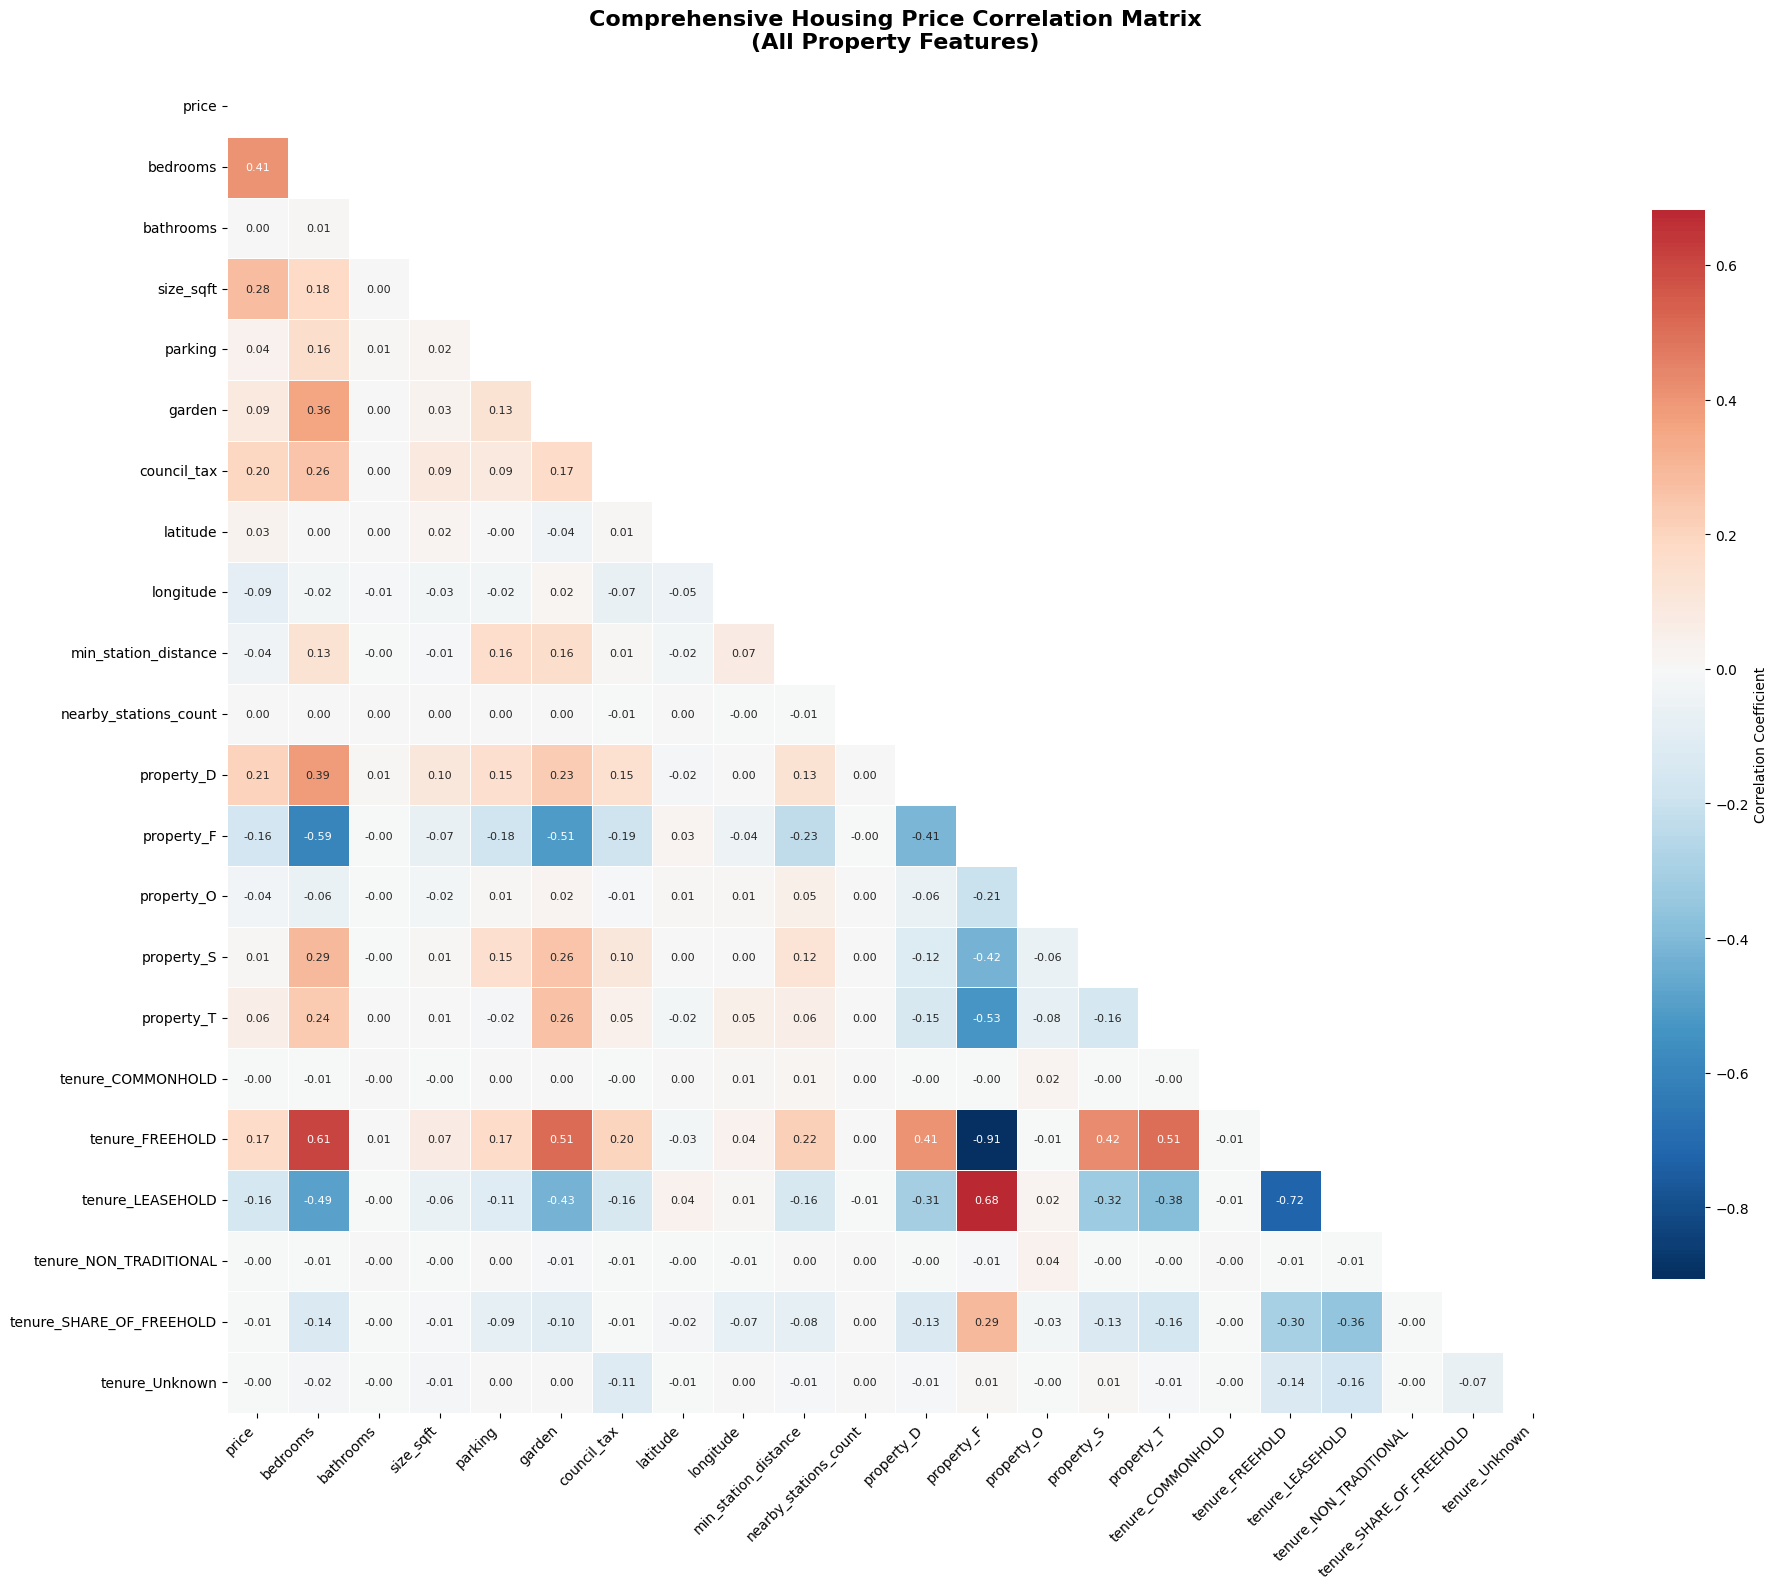

✅ Housing heatmap created successfully!

=== CREATING CRIME RATE VS PRICE HEATMAP ===
Found 16 annual crime categories:
  - annual_crime_anti_social_behaviour
  - annual_crime_bicycle_theft
  - annual_crime_burglary
  - annual_crime_criminal_damage_arson
  - annual_crime_drugs
Available crime features: 18
Crime correlation dataset: (41835, 18)


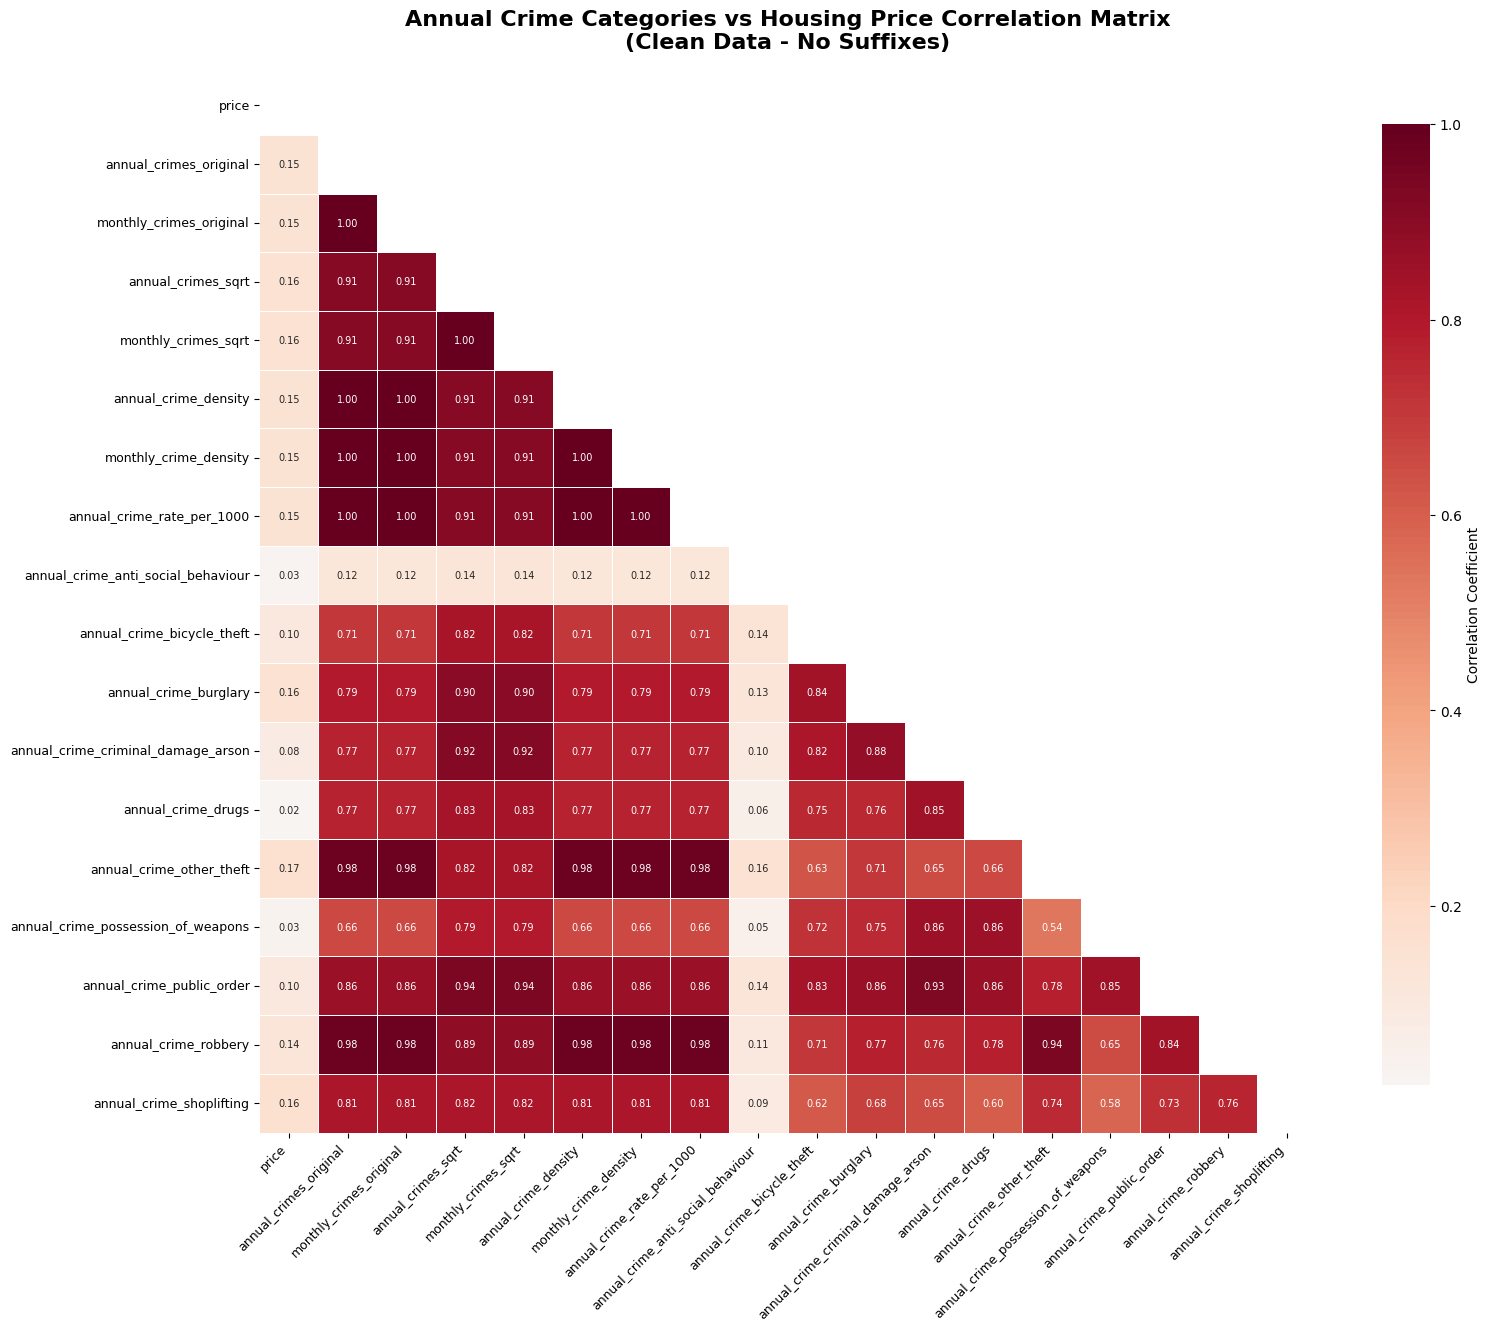

✅ Crime heatmap created successfully!

📊 PRICE CORRELATIONS:
------------------------------------------------------------
annual_crime_other_theft           :   0.165 ↑ (Weak)
annual_crime_shoplifting           :   0.160 ↑ (Weak)
annual_crime_burglary              :   0.157 ↑ (Weak)
monthly_crimes_sqrt                :   0.156 ↑ (Weak)
annual_crimes_sqrt                 :   0.156 ↑ (Weak)
monthly_crime_density              :   0.150 ↑ (Weak)
monthly_crimes_original            :   0.150 ↑ (Weak)
annual_crime_rate_per_1000         :   0.150 ↑ (Weak)
annual_crimes_original             :   0.150 ↑ (Weak)
annual_crime_density               :   0.150 ↑ (Weak)
annual_crime_robbery               :   0.135 ↑ (Weak)
annual_crime_bicycle_theft         :   0.104 ↑ (Weak)
annual_crime_public_order          :   0.102 ↑ (Weak)
annual_crime_criminal_damage_arson :   0.082 ↑ (Weak)
annual_crime_possession_of_weapons :   0.033 ↑ (Weak)
annual_crime_anti_social_behaviour :   0.030 ↑ (Weak)
annual_crime_d

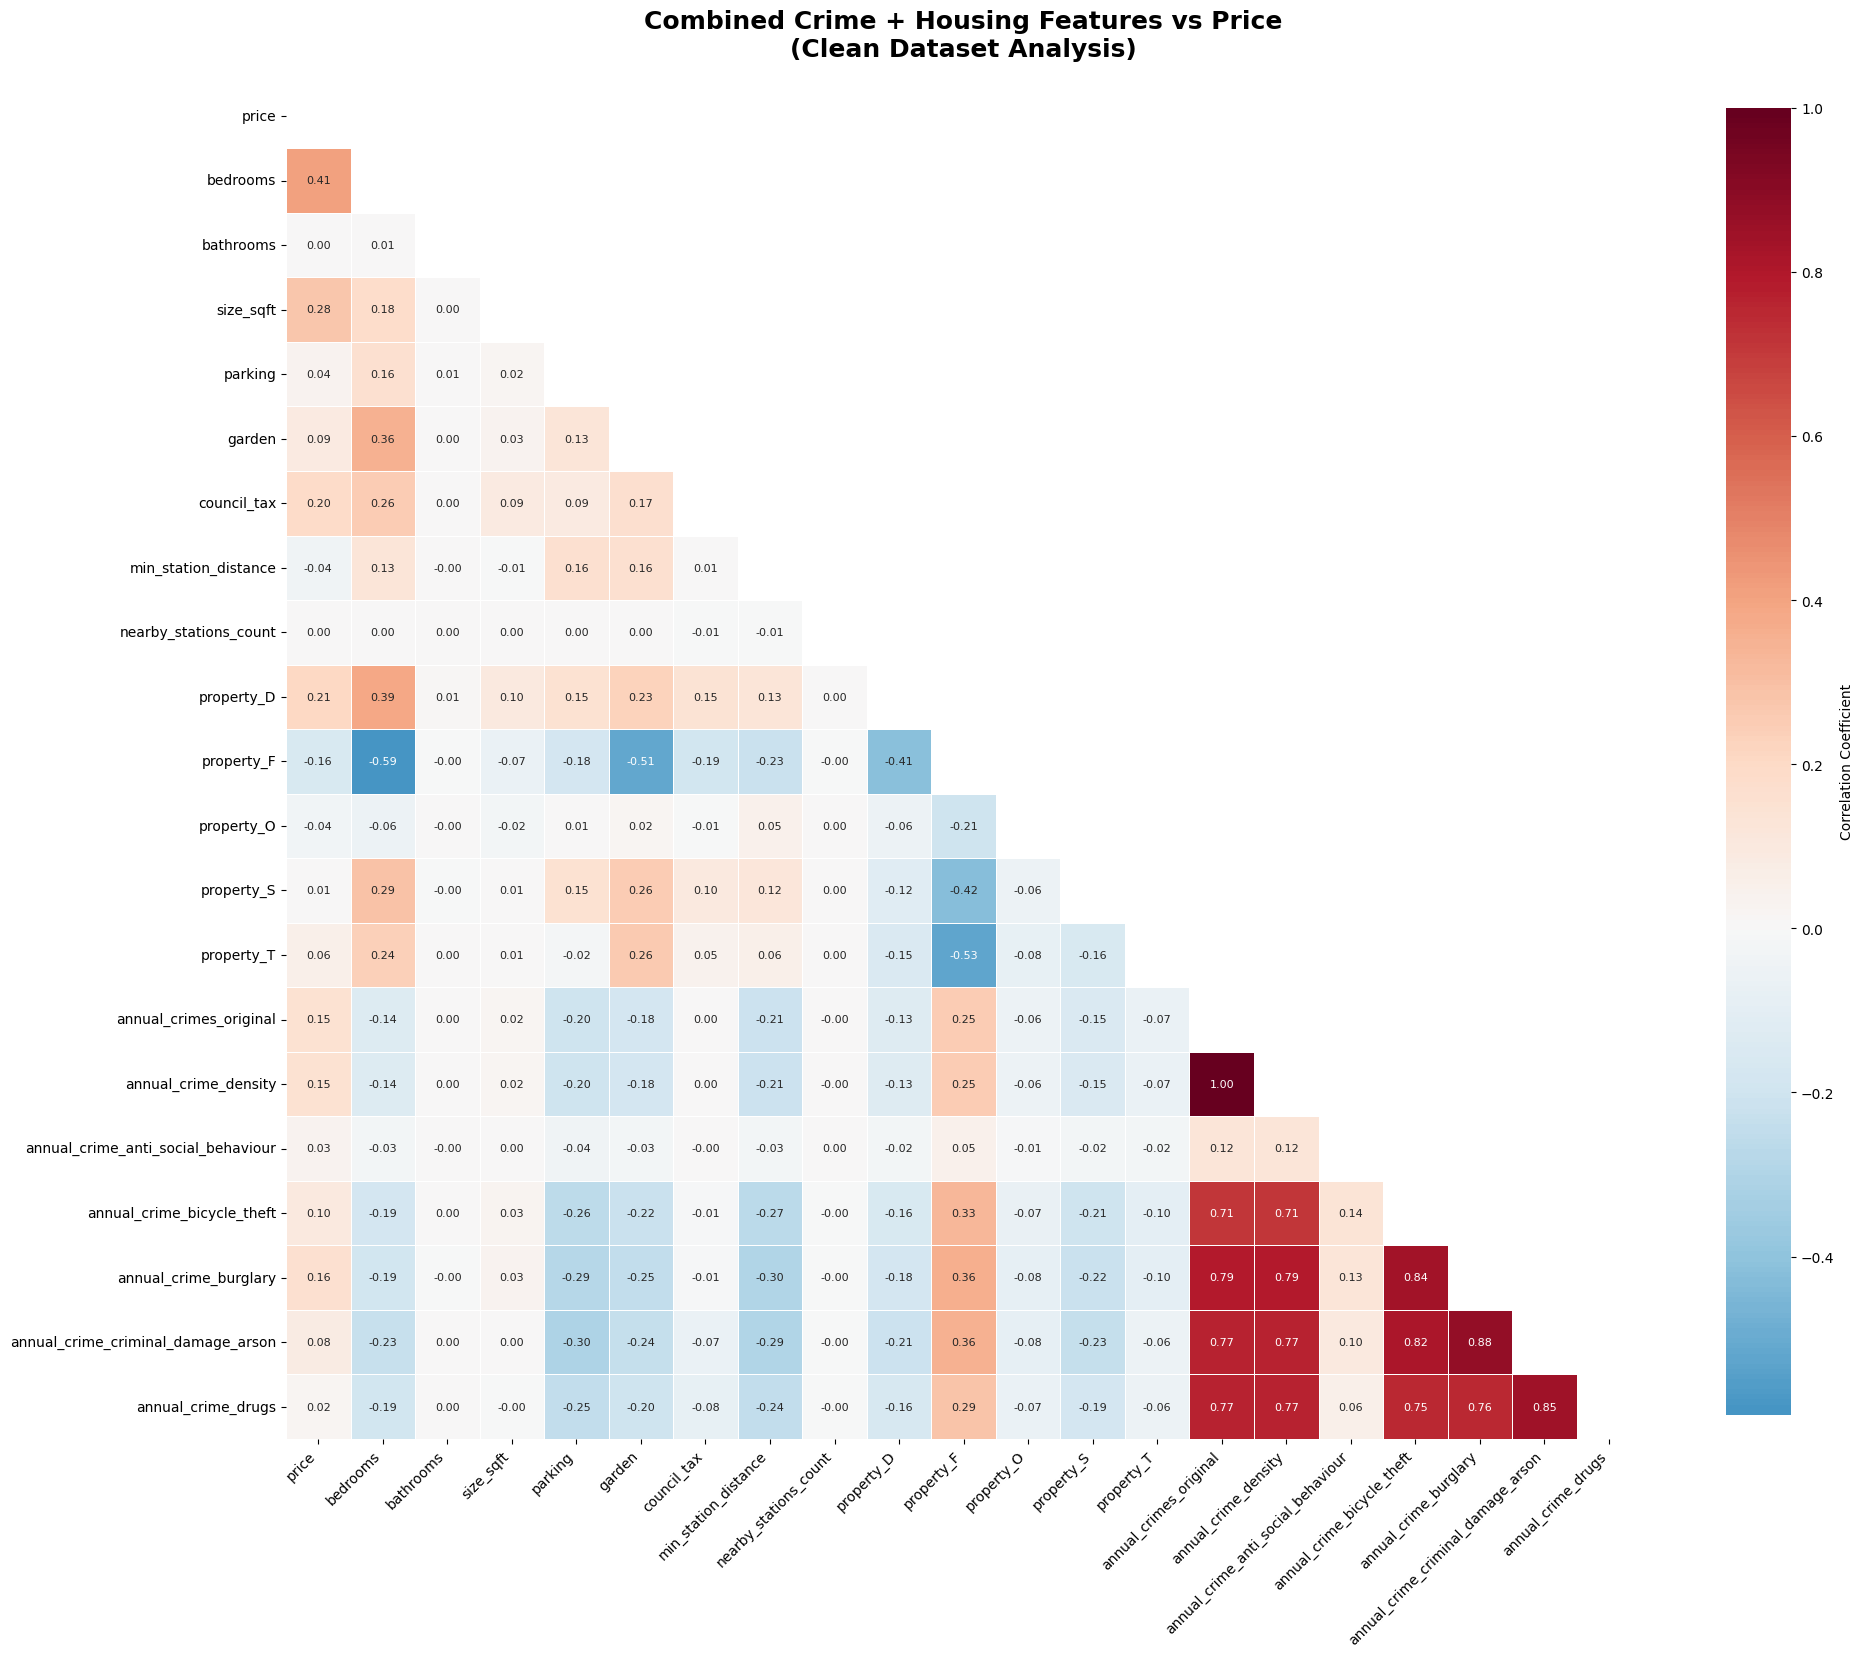

✅ Combined heatmap created successfully!
📁 Final analysis dataset saved: C:\Users\Jc\Desktop\Dissertation\Code\housing_crime_analysis_final.csv

📊 TOP 10 PRICE CORRELATIONS:
----------------------------------------------------------------------
bedrooms                           :   0.408 ↑ (Moderate) [HOUSING]
size_sqft                          :   0.278 ↑ (Weak) [HOUSING]
property_D                         :   0.205 ↑ (Weak) [HOUSING]
council_tax                        :   0.197 ↑ (Weak) [HOUSING]
property_F                         :  -0.163 ↓ (Weak) [HOUSING]
annual_crime_burglary              :   0.157 ↑ (Weak) [CRIME]
annual_crimes_original             :   0.150 ↑ (Weak) [CRIME]
annual_crime_density               :   0.150 ↑ (Weak) [CRIME]
annual_crime_bicycle_theft         :   0.104 ↑ (Weak) [CRIME]

✅ Heatmap analysis complete!
📊 Generated heatmaps:
   - comprehensive_housing_heatmap.png
   - crime_price_heatmap_clean.png
   - combined_crime_housing_heatmap_clean.png
📈 Final ana

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the CLEAN merged data
df_merged = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv')

def create_crime_price_heatmaps_fixed(df_merged):
    """
    Create heatmaps using clean crime data with proper data type handling
    """
    print("\n" + "="*80)
    print("CREATING CRIME-PRICE HEATMAPS WITH CLEAN DATA (FIXED)")
    print("="*80)
    
    print(f"Dataset shape: {df_merged.shape}")
    print(f"Sample columns: {list(df_merged.columns[:10])}")
    
    # Check current data types
    print(f"\n🔍 CHECKING DATA TYPES:")
    object_cols = df_merged.select_dtypes(include=['object']).columns.tolist()
    print(f"Object columns: {object_cols}")
    
    # Convert all necessary columns to numeric first
    print(f"\n🔄 CONVERTING DATA TYPES...")
    
    # Convert price to numeric
    if 'price' in df_merged.columns:
        df_merged['price'] = pd.to_numeric(df_merged['price'], errors='coerce')
        print(f"Converted price to numeric")
    
    # Convert boolean columns to int
    for col in df_merged.columns:
        if df_merged[col].dtype == 'bool':
            df_merged[col] = df_merged[col].astype(int)
            print(f"Converted {col} from bool to int")
    
    # Convert numeric-like object columns
    numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 'council_tax',
                   'latitude', 'longitude', 'min_station_distance']
    
    for col in numeric_cols:
        if col in df_merged.columns:
            df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')
            print(f"Converted {col} to numeric")
    
    # Handle crime columns
    crime_cols = [col for col in df_merged.columns if 'crime' in col.lower() and not col.endswith('_type')]
    for col in crime_cols:
        df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')
    
    print(f"Converted {len(crime_cols)} crime columns to numeric")
    
    # Find the correct total crimes column for transformations
    total_crimes_col = None
    monthly_crimes_col = None
    
    for col in df_merged.columns:
        if 'annual_total_crimes' in col.lower():
            total_crimes_col = col
        elif 'average_monthly_crimes' in col.lower():
            monthly_crimes_col = col
    
    print(f"Total crimes column: {total_crimes_col}")
    print(f"Monthly crimes column: {monthly_crimes_col}")
    
    if total_crimes_col and monthly_crimes_col:
        # Create crime transformations
        print(f"\n📊 Creating crime rate transformations...")
        df_merged['annual_crimes_original'] = df_merged[total_crimes_col]
        df_merged['monthly_crimes_original'] = df_merged[monthly_crimes_col]
        
        # Square root transformation
        df_merged['annual_crimes_sqrt'] = np.sqrt(df_merged[total_crimes_col].fillna(0))
        df_merged['monthly_crimes_sqrt'] = np.sqrt(df_merged[monthly_crimes_col].fillna(0))
        
        # Crime density (crimes per square mile in 0.5 mile radius)
        radius_miles = 0.5
        area_sq_miles = np.pi * (radius_miles ** 2)
        df_merged['annual_crime_density'] = df_merged[total_crimes_col] / area_sq_miles
        df_merged['monthly_crime_density'] = df_merged[monthly_crimes_col] / area_sq_miles
        
        # Crime rate per 1000 (standardized)
        df_merged['annual_crime_rate_per_1000'] = (df_merged[total_crimes_col] / area_sq_miles) * 1000
    
    # 1. COMPREHENSIVE HOUSING PRICE CORRELATION MATRIX
    print("\n=== CREATING COMPREHENSIVE HOUSING PRICE HEATMAP ===")
    
    # Select ONLY numeric housing features (exclude text columns)
    housing_features = [
        'price', 'bedrooms', 'bathrooms', 'size_sqft', 
        'parking', 'garden', 'council_tax',
        'latitude', 'longitude', 'min_station_distance', 'nearby_stations_count'
    ]
    
    # Add ONLY dummy variables (property_ and tenure_ columns that are numeric)
    dummy_cols = [col for col in df_merged.columns 
                  if (col.startswith('property_') or col.startswith('tenure_')) 
                  and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']]
    
    housing_features.extend(dummy_cols)
    
    # Filter available features and ensure they're numeric
    available_housing_features = []
    for col in housing_features:
        if col in df_merged.columns and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            available_housing_features.append(col)
    
    print(f"Available numeric housing features: {len(available_housing_features)}")
    print(f"Features: {available_housing_features}")
    
    if len(available_housing_features) > 1:
        # Create housing correlation dataset
        df_housing_corr = df_merged[available_housing_features].copy()
        
        # Fill NaN values
        df_housing_corr = df_housing_corr.fillna(0)
        
        print(f"Housing correlation dataset: {df_housing_corr.shape}")
        
        # Housing correlation matrix
        housing_correlation_matrix = df_housing_corr.corr()
        
        # Plot comprehensive housing heatmap
        plt.figure(figsize=(20, 16))
        mask = np.triu(np.ones_like(housing_correlation_matrix, dtype=bool))
        
        sns.heatmap(housing_correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 8})
        
        plt.title('Comprehensive Housing Price Correlation Matrix\n(All Property Features)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\comprehensive_housing_heatmap.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Housing heatmap created successfully!")
    
    # 2. CRIME RATE VS PRICE HEATMAP
    print("\n=== CREATING CRIME RATE VS PRICE HEATMAP ===")
    
    # Find annual crime category columns (numeric only)
    annual_crime_categories = [col for col in df_merged.columns 
                              if col.startswith('annual_crime_') 
                              and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']]
    
    print(f"Found {len(annual_crime_categories)} annual crime categories:")
    for cat in annual_crime_categories[:5]:
        print(f"  - {cat}")
    
    # Select crime features (only numeric)
    crime_features = ['price']
    
    # Add transformation columns if they exist
    transformation_cols = ['annual_crimes_original', 'monthly_crimes_original',
                          'annual_crimes_sqrt', 'monthly_crimes_sqrt',
                          'annual_crime_density', 'monthly_crime_density',
                          'annual_crime_rate_per_1000']
    
    for col in transformation_cols:
        if col in df_merged.columns and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            crime_features.append(col)
    
    # Add annual crime categories (limit to avoid overcrowding)
    crime_features.extend(annual_crime_categories[:10])
    
    # Filter available crime features
    available_crime_features = [col for col in crime_features if col in df_merged.columns]
    print(f"Available crime features: {len(available_crime_features)}")
    
    if len(available_crime_features) > 1:
        # Create crime correlation dataset
        df_crime_corr = df_merged[available_crime_features].copy()
        
        # Fill NaN values
        df_crime_corr = df_crime_corr.fillna(0)
        
        print(f"Crime correlation dataset: {df_crime_corr.shape}")
        
        # Crime correlation matrix
        crime_correlation_matrix = df_crime_corr.corr()
        
        # Plot crime rate heatmap
        plt.figure(figsize=(16, 14))
        crime_mask = np.triu(np.ones_like(crime_correlation_matrix, dtype=bool))
        
        sns.heatmap(crime_correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=crime_mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 7})
        
        plt.title('Annual Crime Categories vs Housing Price Correlation Matrix\n(Clean Data - No Suffixes)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\crime_price_heatmap_clean.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Crime heatmap created successfully!")
        
        # Show price correlations
        if 'price' in crime_correlation_matrix.columns:
            price_corrs = crime_correlation_matrix['price'].sort_values(key=abs, ascending=False)
            print(f"\n📊 PRICE CORRELATIONS:")
            print("-" * 60)
            for feature, corr in price_corrs.items():
                if feature != 'price':
                    direction = "↑" if corr > 0 else "↓"
                    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                    print(f"{feature:<35}: {corr:>7.3f} {direction} ({strength})")
    
    # 3. COMBINED HEATMAP
    print("\n=== CREATING COMBINED CRIME + HOUSING HEATMAP ===")
    
    # Select key features for combined analysis (all numeric)
    combined_features = [
        'price', 'bedrooms', 'bathrooms', 'size_sqft', 
        'parking', 'garden', 'council_tax',
        'min_station_distance', 'nearby_stations_count'
    ]
    
    # Add property dummies (limit to avoid overcrowding) - only numeric ones
    property_dummies_limited = [col for col in df_merged.columns 
                               if col.startswith('property_') 
                               and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']][:5]
    combined_features.extend(property_dummies_limited)
    
    # Add key crime features
    key_crime_features = []
    if 'annual_crimes_original' in df_merged.columns:
        key_crime_features.extend(['annual_crimes_original', 'annual_crime_density'])
    
    # Add top 5 crime categories
    key_crime_features.extend(annual_crime_categories[:5])
    combined_features.extend(key_crime_features)
    
    # Filter available combined features (ensure all are numeric)
    available_combined_features = []
    for col in combined_features:
        if col in df_merged.columns and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            available_combined_features.append(col)
    
    print(f"Available combined features: {len(available_combined_features)}")
    
    if len(available_combined_features) > 1:
        # Create combined correlation dataset
        df_combined_corr = df_merged[available_combined_features].copy()
        
        # Fill NaN values
        df_combined_corr = df_combined_corr.fillna(0)
        
        print(f"Combined correlation dataset: {df_combined_corr.shape}")
        
        # Combined correlation matrix
        combined_correlation_matrix = df_combined_corr.corr()
        
        # Plot combined heatmap
        plt.figure(figsize=(20, 18))
        combined_mask = np.triu(np.ones_like(combined_correlation_matrix, dtype=bool))
        
        sns.heatmap(combined_correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=combined_mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 8})
        
        plt.title('Combined Crime + Housing Features vs Price\n(Clean Dataset Analysis)', 
                  fontsize=18, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\combined_crime_housing_heatmap_clean.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Combined heatmap created successfully!")
        
        # Save final dataset
        output_file = r'C:\Users\Jc\Desktop\Dissertation\Code\housing_crime_analysis_final.csv'
        df_combined_corr.to_csv(output_file, index=False)
        print(f"📁 Final analysis dataset saved: {output_file}")
        
        # Show summary of strongest correlations
        if 'price' in combined_correlation_matrix.columns:
            price_corrs = combined_correlation_matrix['price'].sort_values(key=abs, ascending=False)
            print(f"\n📊 TOP 10 PRICE CORRELATIONS:")
            print("-" * 70)
            for i, (feature, corr) in enumerate(price_corrs.items()):
                if feature != 'price' and i < 10:
                    direction = "↑" if corr > 0 else "↓"
                    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                    feature_type = "CRIME" if 'crime' in feature.lower() else "HOUSING"
                    print(f"{feature:<35}: {corr:>7.3f} {direction} ({strength}) [{feature_type}]")
        
        return df_combined_corr
    
    print("⚠️ Could not create all heatmaps - check data availability")
    return None

# Execute the fixed analysis
print("🔍 Starting FIXED heatmap analysis with proper data types...")
print("📊 Using the clean merged dataset with numeric-only correlation")

# Check the dataset first
print(f"\nDataset info:")
print(f"Shape: {df_merged.shape}")
print(f"Columns: {list(df_merged.columns[:10])}...")

# Check data types
print(f"\nData types summary:")
print(df_merged.dtypes.value_counts())

# Run the fixed analysis
df_final = create_crime_price_heatmaps_fixed(df_merged)

if df_final is not None:
    print(f"\n✅ Heatmap analysis complete!")
    print(f"📊 Generated heatmaps:")
    print(f"   - comprehensive_housing_heatmap.png")
    print(f"   - crime_price_heatmap_clean.png") 
    print(f"   - combined_crime_housing_heatmap_clean.png")
    print(f"📈 Final analysis dataset: housing_crime_analysis_final.csv")
    print(f"🎯 All correlations calculated with numeric data only!")
else:
    print("❌ Heatmap generation failed - please check data format")

🔍 Starting SIMPLIFIED heatmap analysis (no monthly/density features)...
📊 Using only annual crime data and essential transformations

Dataset info:
Shape: (41835, 45)
Columns: ['title', 'bedrooms', 'bathrooms', 'size_sqft', 'price', 'parking', 'garden', 'council_tax', 'latitude', 'longitude']...

Data types summary:
int64      29
float64    11
object      5
Name: count, dtype: int64

CREATING CRIME-PRICE HEATMAPS WITH CLEAN DATA (SIMPLIFIED)
Dataset shape: (41835, 45)
Sample columns: ['title', 'bedrooms', 'bathrooms', 'size_sqft', 'price', 'parking', 'garden', 'council_tax', 'latitude', 'longitude']

🔍 CHECKING DATA TYPES:
Object columns: ['station_distances', 'nearest_stations', 'postcode', 'description', 'nearest_station_name']

🔄 CONVERTING DATA TYPES...
Converted price to numeric
Converted bedrooms to numeric
Converted bathrooms to numeric
Converted size_sqft to numeric
Converted parking to numeric
Converted garden to numeric
Converted council_tax to numeric
Converted latitude to n

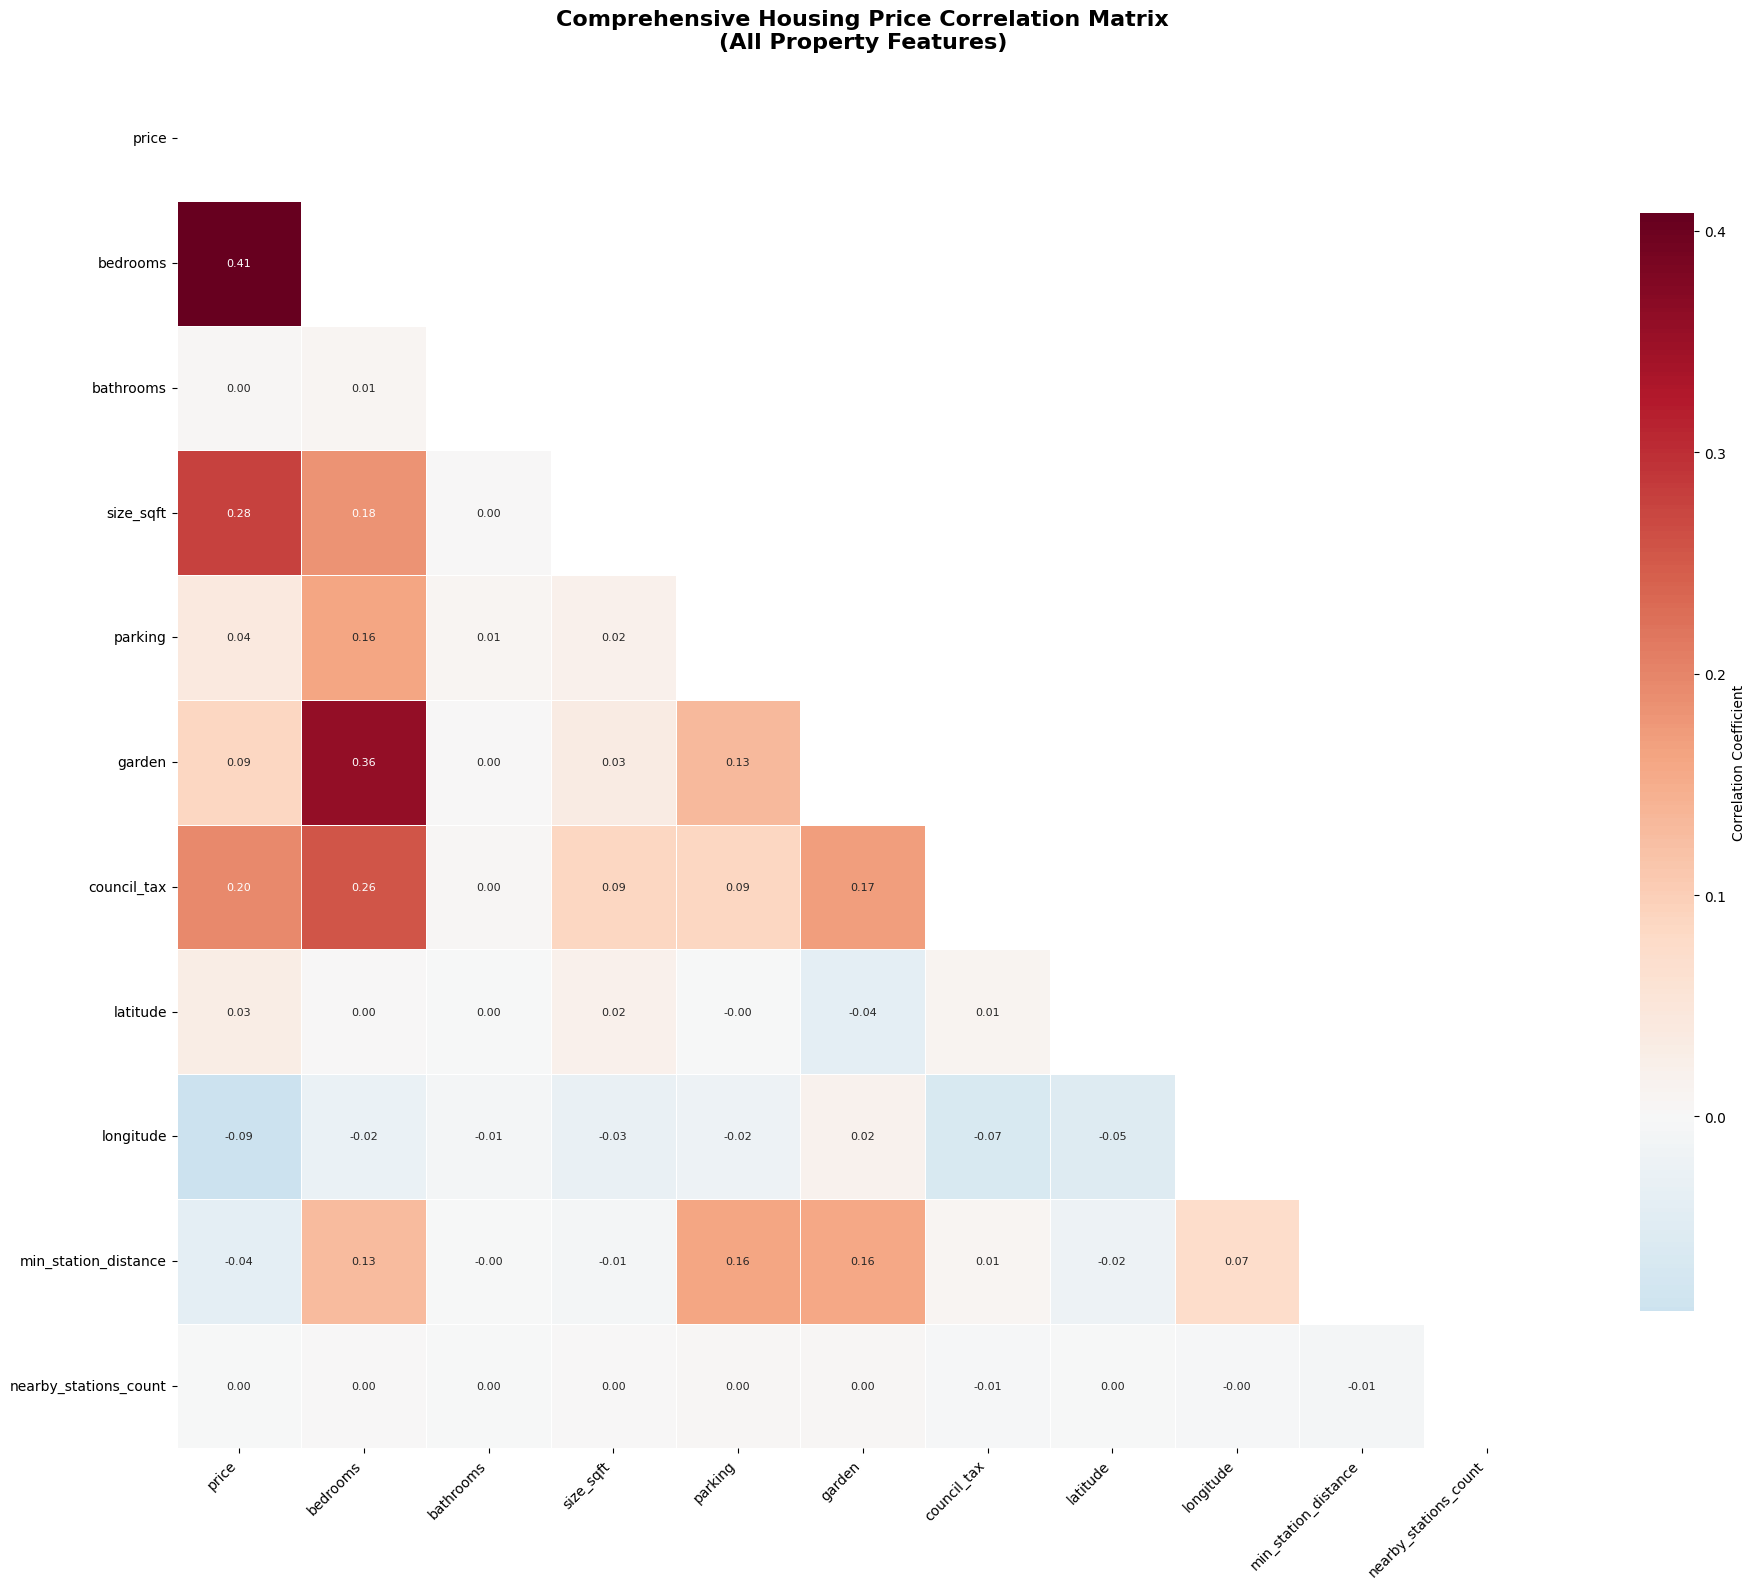

✅ Housing heatmap created successfully!

=== CREATING SIMPLIFIED CRIME RATE VS PRICE HEATMAP ===
Found 14 annual crime categories:
  - annual_crime_anti_social_behaviour
  - annual_crime_bicycle_theft
  - annual_crime_burglary
  - annual_crime_criminal_damage_arson
  - annual_crime_drugs
Added transformation: annual_crimes_original
Added transformation: annual_crimes_sqrt
Available simplified crime features: 13
Crime correlation dataset: (41835, 13)


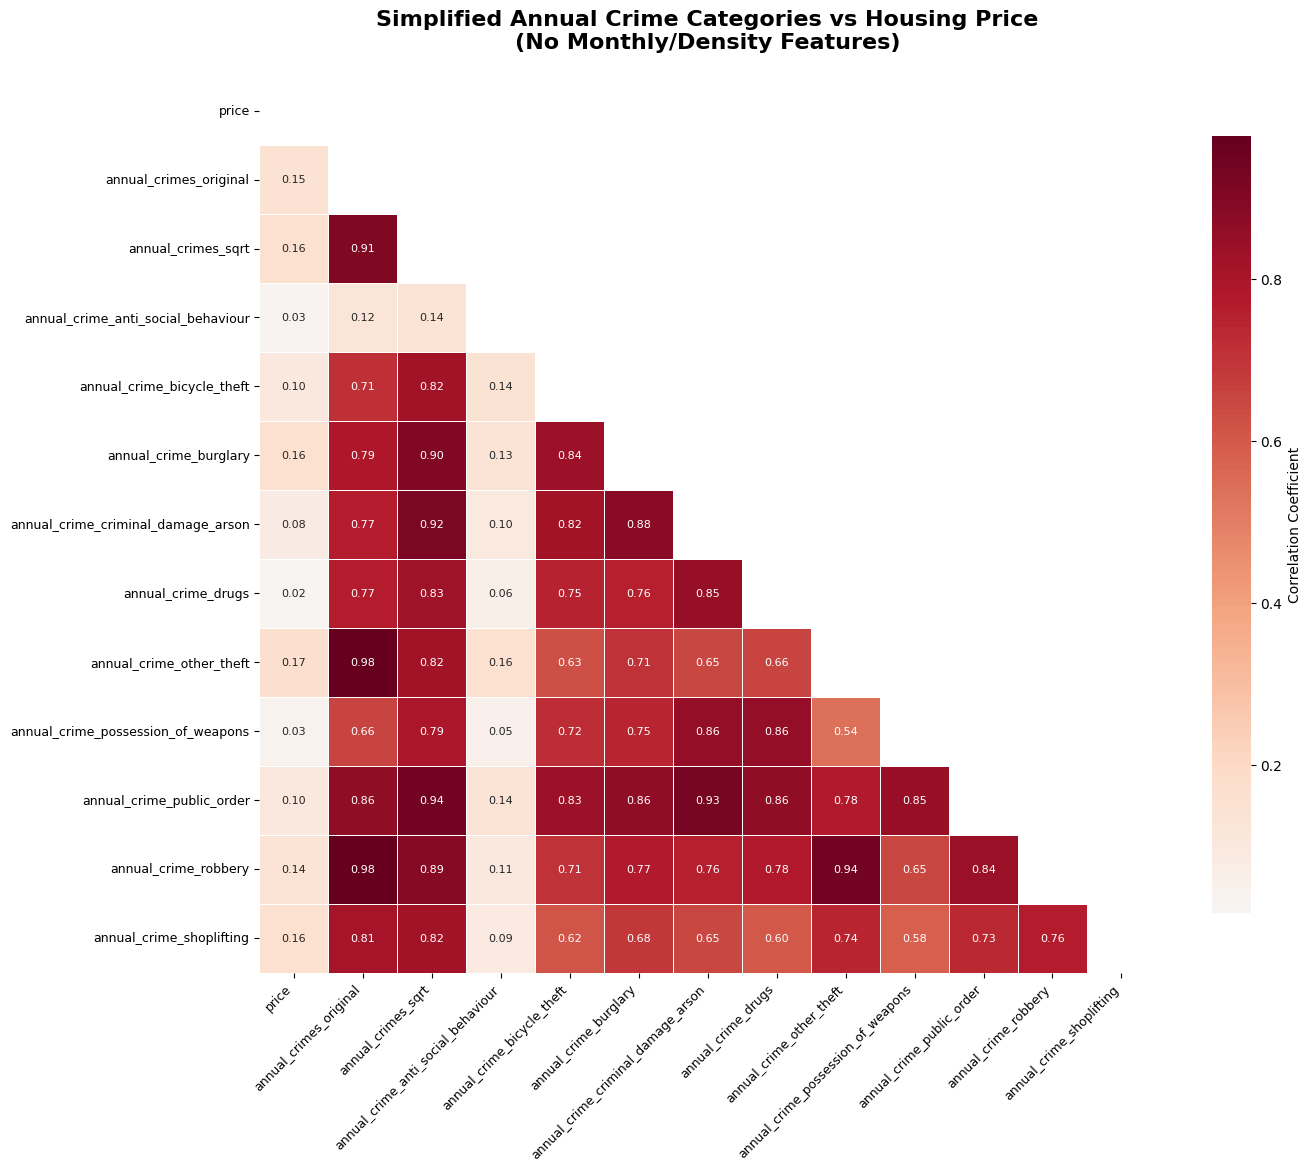

✅ Simplified crime heatmap created successfully!

📊 SIMPLIFIED PRICE CORRELATIONS:
------------------------------------------------------------
annual_crime_other_theft           :   0.165 ↑ (Weak)
annual_crime_shoplifting           :   0.160 ↑ (Weak)
annual_crime_burglary              :   0.157 ↑ (Weak)
annual_crimes_sqrt                 :   0.156 ↑ (Weak)
annual_crimes_original             :   0.150 ↑ (Weak)
annual_crime_robbery               :   0.135 ↑ (Weak)
annual_crime_bicycle_theft         :   0.104 ↑ (Weak)
annual_crime_public_order          :   0.102 ↑ (Weak)
annual_crime_criminal_damage_arson :   0.082 ↑ (Weak)
annual_crime_possession_of_weapons :   0.033 ↑ (Weak)
annual_crime_anti_social_behaviour :   0.030 ↑ (Weak)
annual_crime_drugs                 :   0.017 ↑ (Weak)

=== CREATING SIMPLIFIED COMBINED CRIME + HOUSING HEATMAP ===
Key crime features added: ['annual_crimes_original', 'annual_crimes_sqrt', 'annual_crime_anti_social_behaviour', 'annual_crime_bicycle_theft', 'an

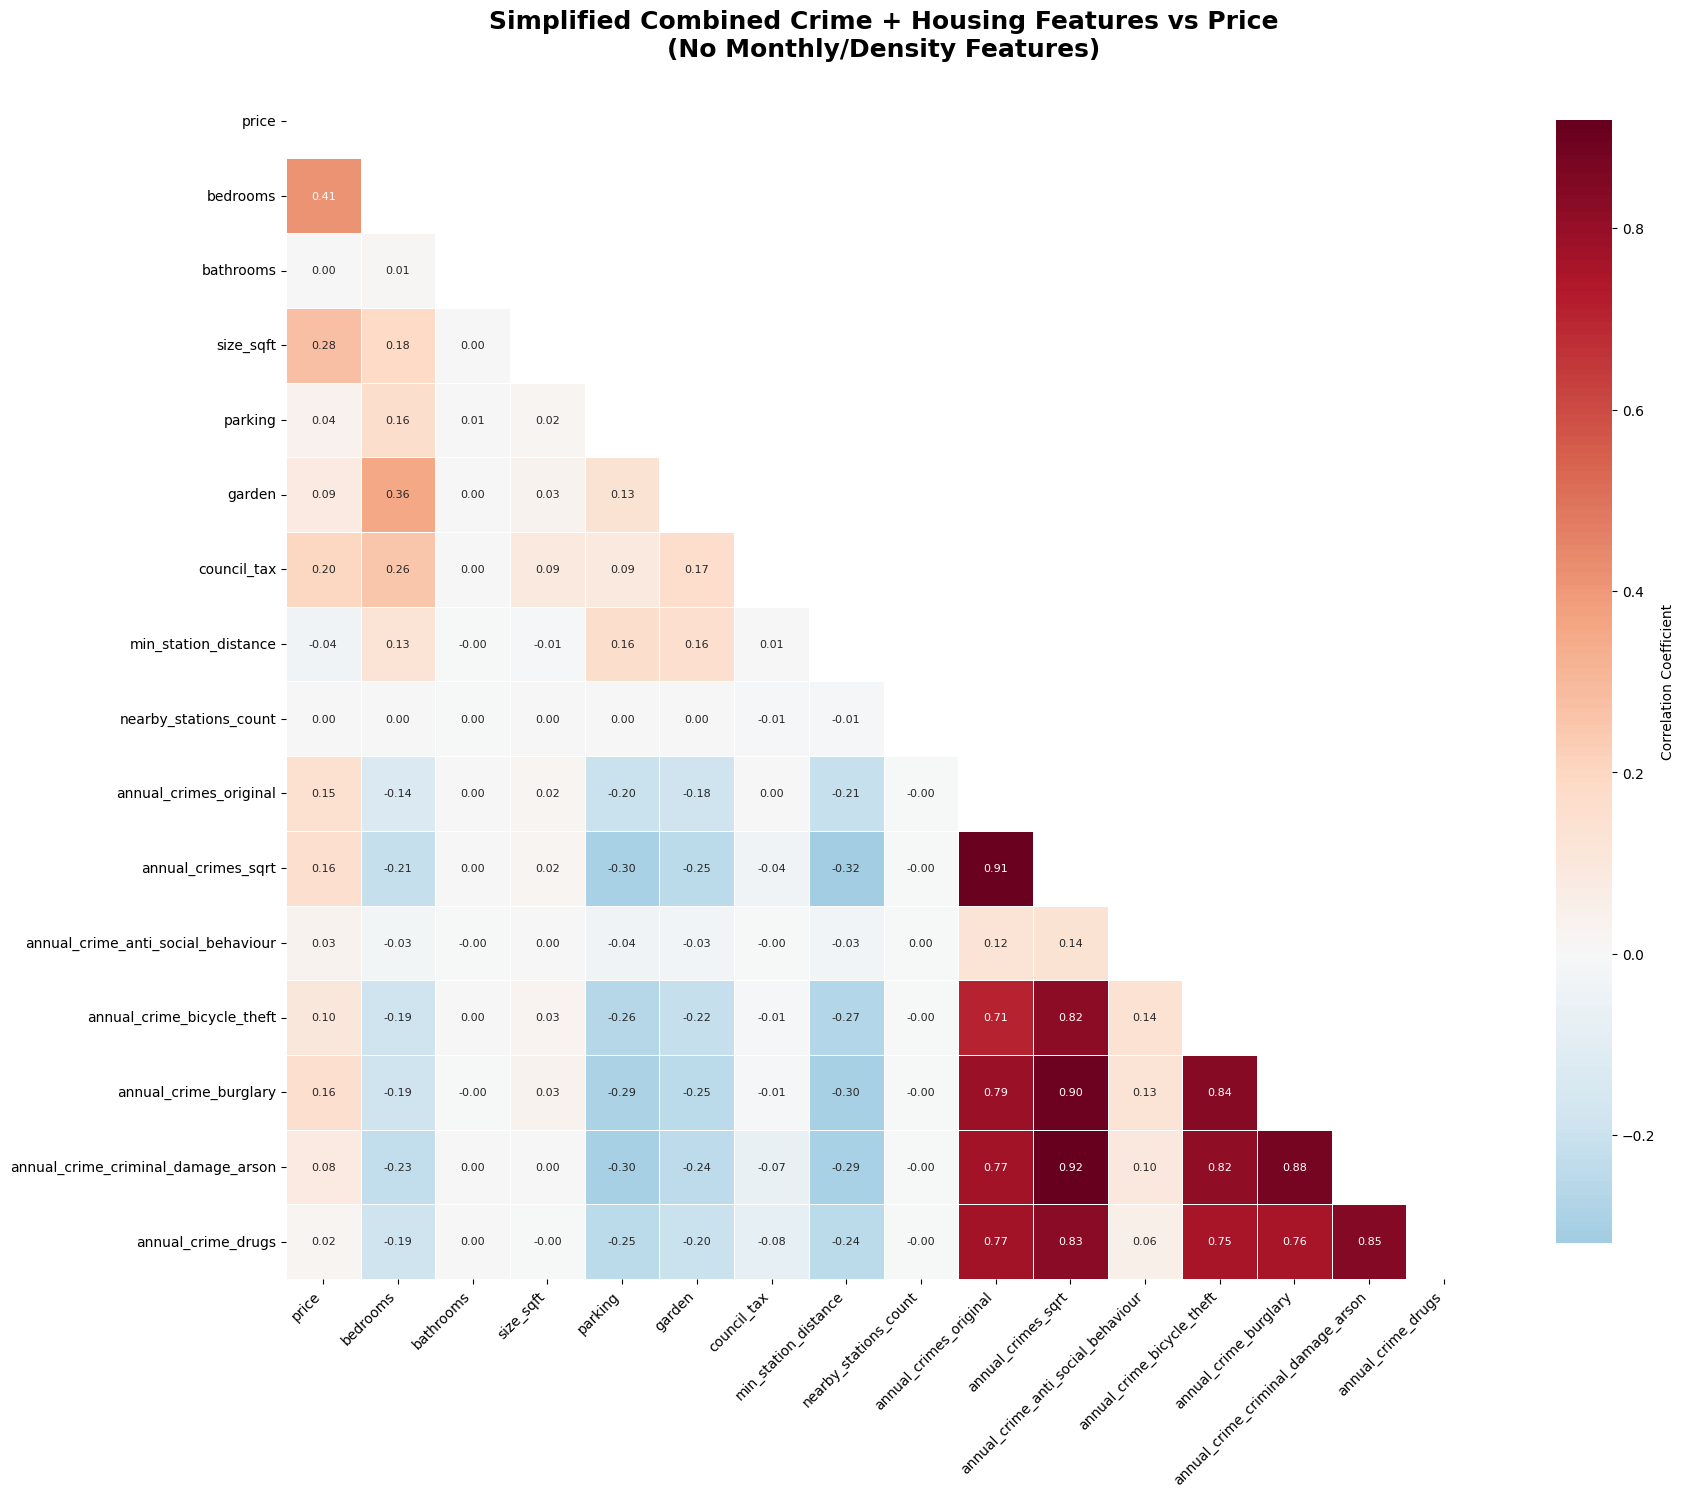

✅ Simplified combined heatmap created successfully!
📁 Simplified analysis dataset saved: C:\Users\Jc\Desktop\Dissertation\Code\housing_crime_analysis_simplified.csv

📊 TOP 10 SIMPLIFIED PRICE CORRELATIONS:
----------------------------------------------------------------------
bedrooms                           :   0.408 ↑ (Moderate) [HOUSING]
size_sqft                          :   0.278 ↑ (Weak) [HOUSING]
council_tax                        :   0.197 ↑ (Weak) [HOUSING]
annual_crime_burglary              :   0.157 ↑ (Weak) [CRIME]
annual_crimes_sqrt                 :   0.156 ↑ (Weak) [CRIME]
annual_crimes_original             :   0.150 ↑ (Weak) [CRIME]
annual_crime_bicycle_theft         :   0.104 ↑ (Weak) [CRIME]
garden                             :   0.087 ↑ (Weak) [HOUSING]
annual_crime_criminal_damage_arson :   0.082 ↑ (Weak) [CRIME]

✅ Simplified heatmap analysis complete!
📊 Generated simplified heatmaps:
   - comprehensive_housing_heatmap.png
   - crime_price_heatmap_simplified.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the CLEAN merged data
df_merged = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv')

def create_crime_price_heatmaps_fixed(df_merged):
    """
    Create heatmaps using clean crime data with proper data type handling
    REMOVED: monthly crimes and crime density features
    """
    print("\n" + "="*80)
    print("CREATING CRIME-PRICE HEATMAPS WITH CLEAN DATA (SIMPLIFIED)")
    print("="*80)
    
    print(f"Dataset shape: {df_merged.shape}")
    print(f"Sample columns: {list(df_merged.columns[:10])}")
    
    # Check current data types
    print(f"\n🔍 CHECKING DATA TYPES:")
    object_cols = df_merged.select_dtypes(include=['object']).columns.tolist()
    print(f"Object columns: {object_cols}")
    
    # Convert all necessary columns to numeric first
    print(f"\n🔄 CONVERTING DATA TYPES...")
    
    # Convert price to numeric
    if 'price' in df_merged.columns:
        df_merged['price'] = pd.to_numeric(df_merged['price'], errors='coerce')
        print(f"Converted price to numeric")
    
    # Convert boolean columns to int
    for col in df_merged.columns:
        if df_merged[col].dtype == 'bool':
            df_merged[col] = df_merged[col].astype(int)
            print(f"Converted {col} from bool to int")
    
    # Convert numeric-like object columns
    numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 'council_tax',
                   'latitude', 'longitude', 'min_station_distance']
    
    for col in numeric_cols:
        if col in df_merged.columns:
            df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')
            print(f"Converted {col} to numeric")
    
    # Handle crime columns
    crime_cols = [col for col in df_merged.columns if 'crime' in col.lower() and not col.endswith('_type')]
    for col in crime_cols:
        df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')
    
    print(f"Converted {len(crime_cols)} crime columns to numeric")
    
    # Find the correct total crimes column for transformations
    total_crimes_col = None
    
    for col in df_merged.columns:
        if 'annual_total_crimes' in col.lower():
            total_crimes_col = col
            break
    
    print(f"Total crimes column: {total_crimes_col}")
    
    # SIMPLIFIED CRIME TRANSFORMATIONS (NO MONTHLY OR DENSITY)
    if total_crimes_col:
        print(f"\n📊 Creating simplified crime transformations...")
        df_merged['annual_crimes_original'] = df_merged[total_crimes_col]
        
        # Only square root transformation for annual crimes
        df_merged['annual_crimes_sqrt'] = np.sqrt(df_merged[total_crimes_col].fillna(0))
        
        print(f"✅ Created: annual_crimes_original, annual_crimes_sqrt")
    
    # 1. COMPREHENSIVE HOUSING PRICE CORRELATION MATRIX
    print("\n=== CREATING COMPREHENSIVE HOUSING PRICE HEATMAP ===")
    
    # Select ONLY numeric housing features (exclude text columns)
    housing_features = [
        'price', 'bedrooms', 'bathrooms', 'size_sqft', 
        'parking', 'garden', 'council_tax',
        'latitude', 'longitude', 'min_station_distance', 'nearby_stations_count'
    ]
    
    # Add ONLY dummy variables (property_ and tenure_ columns that are numeric)
    dummy_cols = [col for col in df_merged.columns 
                  if (col.startswith('property_') or col.startswith('tenure_')) 
                  and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']]
    
    housing_features.extend(dummy_cols)
    
    # Filter available features and ensure they're numeric
    available_housing_features = []
    for col in housing_features:
        if col in df_merged.columns and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            available_housing_features.append(col)
    
    print(f"Available numeric housing features: {len(available_housing_features)}")
    print(f"Features: {available_housing_features}")
    
    if len(available_housing_features) > 1:
        # Create housing correlation dataset
        df_housing_corr = df_merged[available_housing_features].copy()
        
        # Fill NaN values
        df_housing_corr = df_housing_corr.fillna(0)
        
        print(f"Housing correlation dataset: {df_housing_corr.shape}")
        
        # Housing correlation matrix
        housing_correlation_matrix = df_housing_corr.corr()
        
        # Plot comprehensive housing heatmap
        plt.figure(figsize=(20, 16))
        mask = np.triu(np.ones_like(housing_correlation_matrix, dtype=bool))
        
        sns.heatmap(housing_correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 8})
        
        plt.title('Comprehensive Housing Price Correlation Matrix\n(All Property Features)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\comprehensive_housing_heatmap.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Housing heatmap created successfully!")
    
    # 2. CRIME RATE VS PRICE HEATMAP (SIMPLIFIED)
    print("\n=== CREATING SIMPLIFIED CRIME RATE VS PRICE HEATMAP ===")
    
    # Find annual crime category columns (numeric only)
    annual_crime_categories = [col for col in df_merged.columns 
                              if col.startswith('annual_crime_') 
                              and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']
                              and not any(exclude in col.lower() for exclude in ['density', 'monthly'])]
    
    print(f"Found {len(annual_crime_categories)} annual crime categories:")
    for cat in annual_crime_categories[:5]:
        print(f"  - {cat}")
    
    # Select crime features (SIMPLIFIED - NO MONTHLY OR DENSITY)
    crime_features = ['price']
    
    # Add ONLY essential transformation columns
    essential_transformation_cols = ['annual_crimes_original', 'annual_crimes_sqrt']
    
    for col in essential_transformation_cols:
        if col in df_merged.columns and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            crime_features.append(col)
            print(f"Added transformation: {col}")
    
    # Add annual crime categories (limit to avoid overcrowding)
    crime_features.extend(annual_crime_categories[:10])
    
    # Filter available crime features
    available_crime_features = [col for col in crime_features if col in df_merged.columns]
    print(f"Available simplified crime features: {len(available_crime_features)}")
    
    if len(available_crime_features) > 1:
        # Create crime correlation dataset
        df_crime_corr = df_merged[available_crime_features].copy()
        
        # Fill NaN values
        df_crime_corr = df_crime_corr.fillna(0)
        
        print(f"Crime correlation dataset: {df_crime_corr.shape}")
        
        # Crime correlation matrix
        crime_correlation_matrix = df_crime_corr.corr()
        
        # Plot crime rate heatmap
        plt.figure(figsize=(14, 12))
        crime_mask = np.triu(np.ones_like(crime_correlation_matrix, dtype=bool))
        
        sns.heatmap(crime_correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=crime_mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 8})
        
        plt.title('Simplified Annual Crime Categories vs Housing Price\n(No Monthly/Density Features)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\crime_price_heatmap_simplified.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Simplified crime heatmap created successfully!")
        
        # Show price correlations
        if 'price' in crime_correlation_matrix.columns:
            price_corrs = crime_correlation_matrix['price'].sort_values(key=abs, ascending=False)
            print(f"\n📊 SIMPLIFIED PRICE CORRELATIONS:")
            print("-" * 60)
            for feature, corr in price_corrs.items():
                if feature != 'price':
                    direction = "↑" if corr > 0 else "↓"
                    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                    print(f"{feature:<35}: {corr:>7.3f} {direction} ({strength})")
    
    # 3. COMBINED HEATMAP (SIMPLIFIED)
    print("\n=== CREATING SIMPLIFIED COMBINED CRIME + HOUSING HEATMAP ===")
    
    # Select key features for combined analysis (all numeric)
    combined_features = [
        'price', 'bedrooms', 'bathrooms', 'size_sqft', 
        'parking', 'garden', 'council_tax',
        'min_station_distance', 'nearby_stations_count'
    ]
    
    # Add property dummies (limit to avoid overcrowding) - only numeric ones
    property_dummies_limited = [col for col in df_merged.columns 
                               if col.startswith('property_') 
                               and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']][:5]
    combined_features.extend(property_dummies_limited)
    
    # Add SIMPLIFIED key crime features (NO MONTHLY OR DENSITY)
    key_crime_features = []
    if 'annual_crimes_original' in df_merged.columns:
        key_crime_features.append('annual_crimes_original')
    if 'annual_crimes_sqrt' in df_merged.columns:
        key_crime_features.append('annual_crimes_sqrt')
    
    # Add top 5 annual crime categories (excluding monthly/density)
    simplified_annual_categories = [col for col in annual_crime_categories[:5] 
                                   if not any(exclude in col.lower() for exclude in ['density', 'monthly'])]
    key_crime_features.extend(simplified_annual_categories)
    combined_features.extend(key_crime_features)
    
    print(f"Key crime features added: {key_crime_features}")
    
    # Filter available combined features (ensure all are numeric)
    available_combined_features = []
    for col in combined_features:
        if col in df_merged.columns and df_merged[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            available_combined_features.append(col)
    
    print(f"Available simplified combined features: {len(available_combined_features)}")
    
    if len(available_combined_features) > 1:
        # Create combined correlation dataset
        df_combined_corr = df_merged[available_combined_features].copy()
        
        # Fill NaN values
        df_combined_corr = df_combined_corr.fillna(0)
        
        print(f"Combined correlation dataset: {df_combined_corr.shape}")
        
        # Combined correlation matrix
        combined_correlation_matrix = df_combined_corr.corr()
        
        # Plot combined heatmap
        plt.figure(figsize=(18, 16))
        combined_mask = np.triu(np.ones_like(combined_correlation_matrix, dtype=bool))
        
        sns.heatmap(combined_correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=combined_mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 8})
        
        plt.title('Simplified Combined Crime + Housing Features vs Price\n(No Monthly/Density Features)', 
                  fontsize=18, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\combined_crime_housing_heatmap_simplified.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Simplified combined heatmap created successfully!")
        
        # Save final dataset
        output_file = r'C:\Users\Jc\Desktop\Dissertation\Code\housing_crime_analysis_simplified.csv'
        df_combined_corr.to_csv(output_file, index=False)
        print(f"📁 Simplified analysis dataset saved: {output_file}")
        
        # Show summary of strongest correlations
        if 'price' in combined_correlation_matrix.columns:
            price_corrs = combined_correlation_matrix['price'].sort_values(key=abs, ascending=False)
            print(f"\n📊 TOP 10 SIMPLIFIED PRICE CORRELATIONS:")
            print("-" * 70)
            for i, (feature, corr) in enumerate(price_corrs.items()):
                if feature != 'price' and i < 10:
                    direction = "↑" if corr > 0 else "↓"
                    strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                    feature_type = "CRIME" if 'crime' in feature.lower() else "HOUSING"
                    print(f"{feature:<35}: {corr:>7.3f} {direction} ({strength}) [{feature_type}]")
        
        return df_combined_corr
    
    print("⚠️ Could not create all heatmaps - check data availability")
    return None

# Execute the simplified analysis
print("🔍 Starting SIMPLIFIED heatmap analysis (no monthly/density features)...")
print("📊 Using only annual crime data and essential transformations")

# Check the dataset first
print(f"\nDataset info:")
print(f"Shape: {df_merged.shape}")
print(f"Columns: {list(df_merged.columns[:10])}...")

# Check data types
print(f"\nData types summary:")
print(df_merged.dtypes.value_counts())

# Run the simplified analysis
df_final = create_crime_price_heatmaps_fixed(df_merged)

if df_final is not None:
    print(f"\n✅ Simplified heatmap analysis complete!")
    print(f"📊 Generated simplified heatmaps:")
    print(f"   - comprehensive_housing_heatmap.png")
    print(f"   - crime_price_heatmap_simplified.png") 
    print(f"   - combined_crime_housing_heatmap_simplified.png")
    print(f"📈 Simplified analysis dataset: housing_crime_analysis_simplified.csv")
    print(f"🎯 Removed monthly and density features for cleaner analysis!")
else:
    print("❌ Heatmap generation failed - please check data format")

🚀 Creating finalized baseline dataset with categorical features...
🔧 FIXED: Handles UTF-8 encoding issues
📊 Heatmap will use dummy variables for correlation analysis
📁 Final CSV will keep ONLY original categorical columns for ML
🗑️ NO dummy variables in final CSV
CREATING FINALIZED BASELINE DATASET (WITH CATEGORICAL FEATURES)
🔄 Attempting to load CSV with UTF-8 encoding...


C:\Users\Jc\AppData\Local\Temp\ipykernel_22904\806022406.py:21: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,45,47,48,51,52,55,58,60,61,64,65,68,77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv')


✅ UTF-8 encoding successful!
Original dataset shape: (41826, 79)

🏠 SELECTING HOUSING FEATURES...
Required housing features: ['price', 'bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 'council_tax', 'min_station_distance', 'nearby_stations_count', 'property_type', 'tenure_type']
Available housing features: ['price', 'bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 'council_tax', 'min_station_distance', 'nearby_stations_count', 'property_type', 'tenure_type']

🔍 PREPARING NUMERIC DATA FOR CORRELATION ANALYSIS...
Using dummy variables for correlation: 2 property + 4 tenure

🔍 IDENTIFYING CRIME FEATURES WITH CORRELATION >0.1...
Found 15 crime columns (excluding monthly)

📊 CRIME FEATURES WITH |CORRELATION| ≥ 0.1:
------------------------------------------------------------
annual_crime_vehicle_crime              :   0.237 ↑ (Weak)
annual_crime_other_theft                :   0.165 ↑ (Weak)
annual_crime_shoplifting                :   0.160 ↑ (Weak)
annual_crime_burglary 

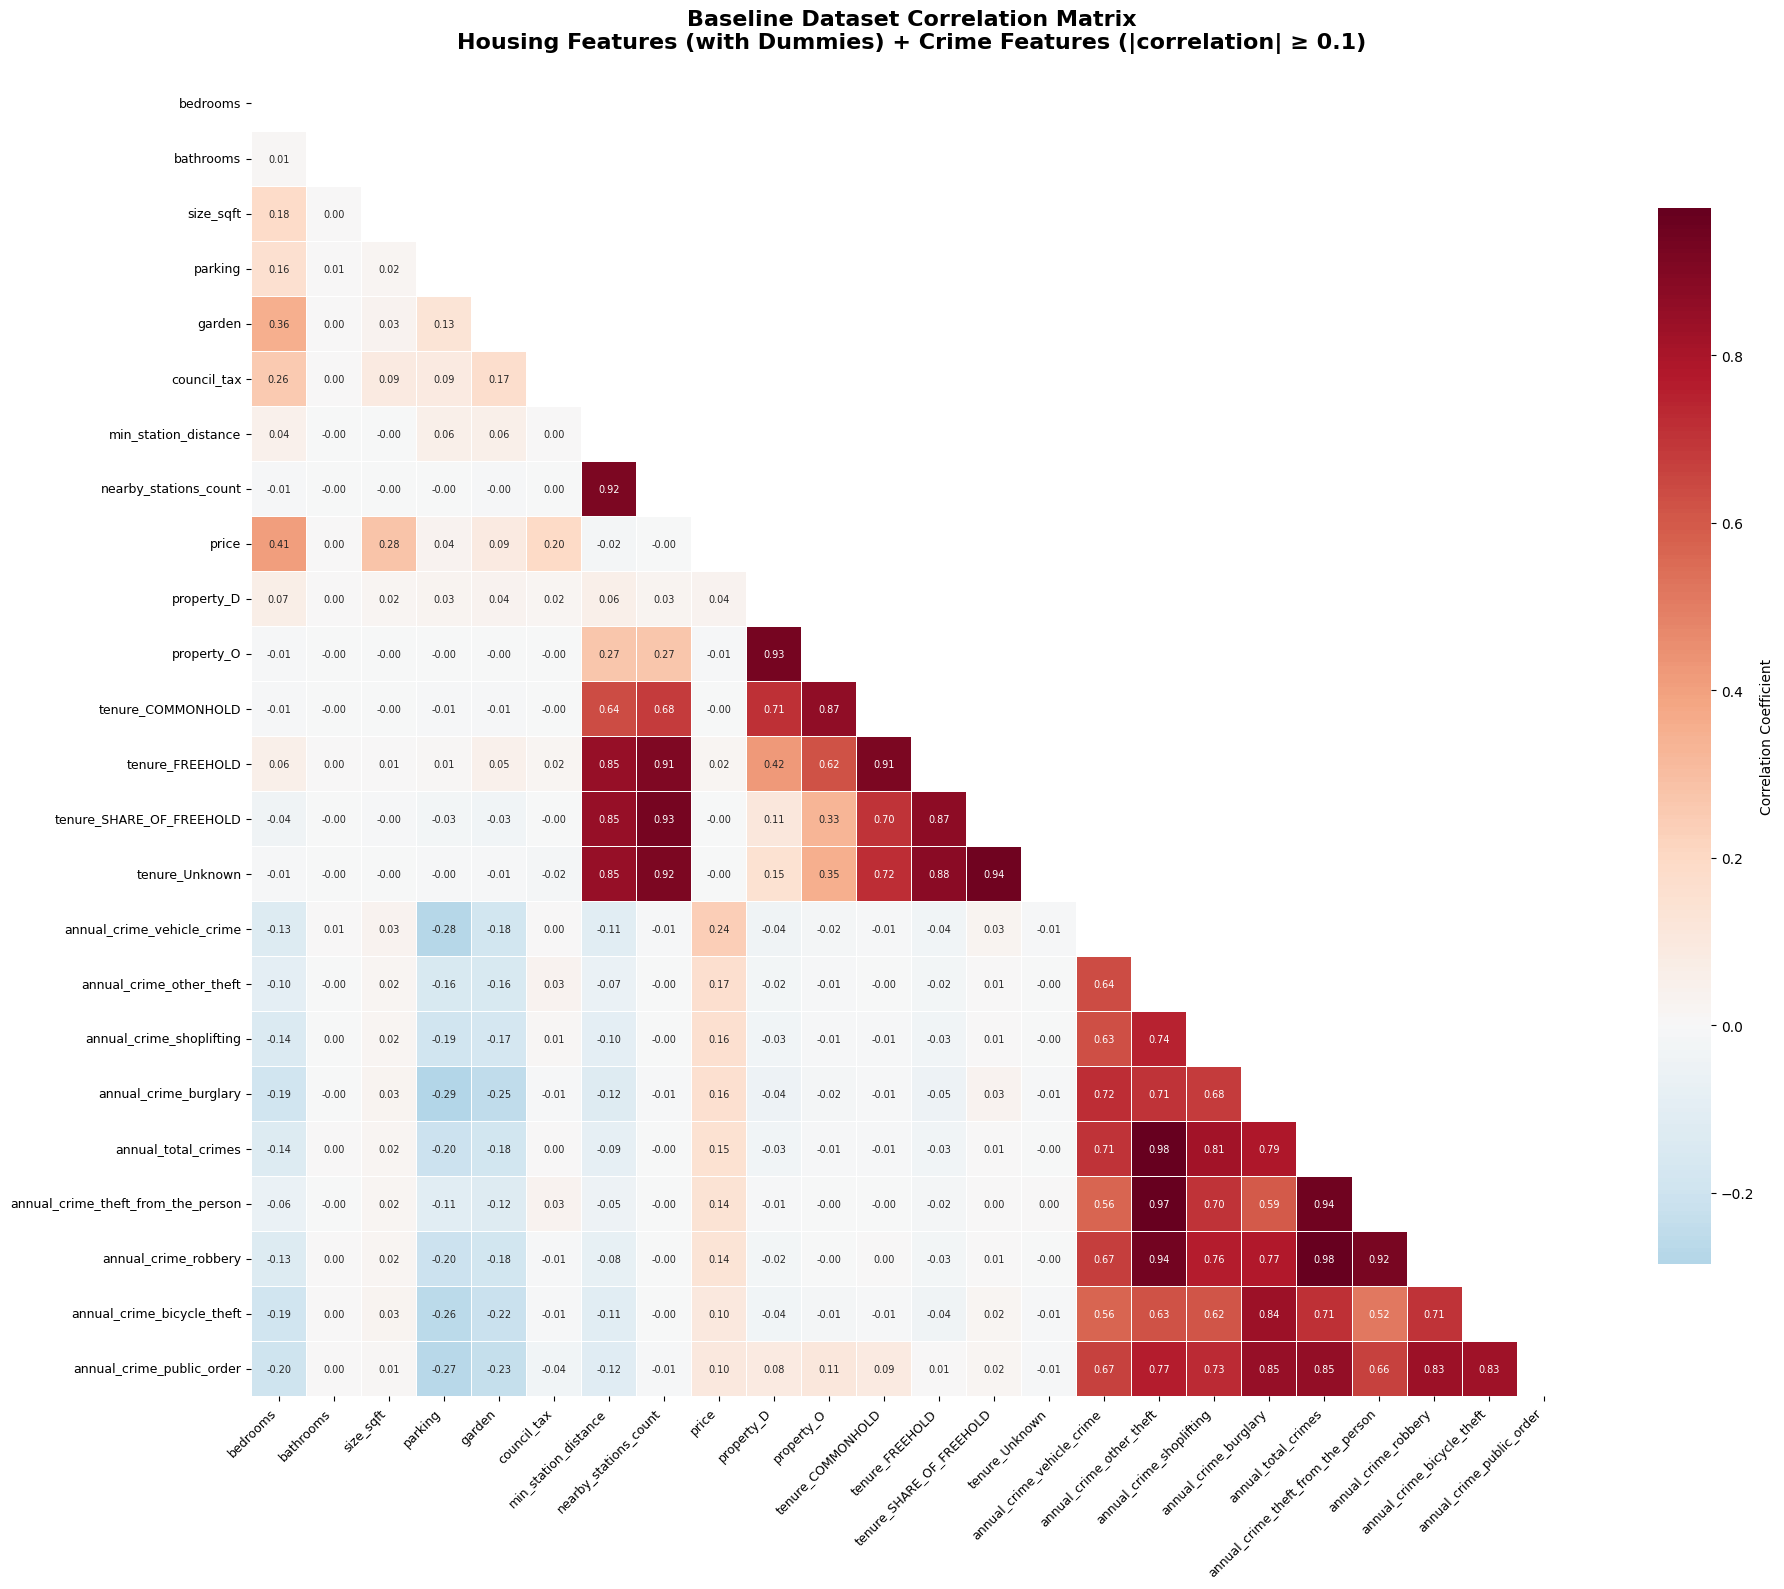

✅ Correlation heatmap created with dummy variables!

🎯 TOP 15 CORRELATIONS WITH PRICE:
----------------------------------------------------------------------
 2. bedrooms                           :   0.408 ↑ (Moderate) [HOUSING]
 3. size_sqft                          :   0.278 ↑ (Weak) [HOUSING]
 4. annual_crime_vehicle_crime         :   0.237 ↑ (Weak) [CRIME]
 5. council_tax                        :   0.197 ↑ (Weak) [HOUSING]
 6. annual_crime_other_theft           :   0.165 ↑ (Weak) [CRIME]
 7. annual_crime_shoplifting           :   0.160 ↑ (Weak) [CRIME]
 8. annual_crime_burglary              :   0.157 ↑ (Weak) [CRIME]
 9. annual_total_crimes                :   0.150 ↑ (Weak) [CRIME]
10. annual_crime_theft_from_the_person :   0.142 ↑ (Weak) [CRIME]
11. annual_crime_robbery               :   0.135 ↑ (Weak) [CRIME]
12. annual_crime_bicycle_theft         :   0.104 ↑ (Weak) [CRIME]
13. annual_crime_public_order          :   0.101 ↑ (Weak) [CRIME]
14. garden                             :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_finalized_baseline_dataset_with_categorical():
    """
    Create finalized dataset with:
    HOUSING: bedrooms, bathrooms, size_sqft, parking, garden, council_tax, 
             min_station_distance, property_type, tenure_type (CATEGORICAL)
    CRIME: Only features with correlation >0.1 with price
    FIXED: Handle UTF-8 encoding issues + Use dummies for correlation analysis but keep original categorical in final dataset
    """
    print("=" * 80)
    print("CREATING FINALIZED BASELINE DATASET (WITH CATEGORICAL FEATURES)")
    print("=" * 80)
    
    # Load the preprocessed data with encoding fix
    try:
        print("🔄 Attempting to load CSV with UTF-8 encoding...")
        df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv')
        print("✅ UTF-8 encoding successful!")
    except UnicodeDecodeError:
        print("⚠️ UTF-8 failed, trying with latin-1 encoding...")
        try:
            df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv', 
                           encoding='latin-1')
            print("✅ Latin-1 encoding successful!")
        except Exception as e:
            print("⚠️ Latin-1 failed, trying with cp1252 encoding...")
            try:
                df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv', 
                               encoding='cp1252')
                print("✅ CP1252 encoding successful!")
            except Exception as e:
                print(f"❌ All encoding attempts failed: {e}")
                print("🔄 Trying with error handling...")
                df = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\housing_composite_crime_SIMPLIFIED.csv', 
                               encoding='utf-8', errors='ignore')
                print("✅ UTF-8 with error ignore successful!")
    
    print(f"Original dataset shape: {df.shape}")
    
    # 1. DEFINE REQUIRED HOUSING FEATURES (INCLUDE CATEGORICAL)
    print(f"\n🏠 SELECTING HOUSING FEATURES...")
    
    # Core housing features (numeric + categorical)
    required_housing_features = [
        'price',  # Target variable
        'bedrooms', 
        'bathrooms', 
        'size_sqft', 
        'parking', 
        'garden', 
        'council_tax',
        'min_station_distance',
        'nearby_stations_count',  # If available
        'property_type',          # CATEGORICAL - for XGBoost/GBM
        'tenure_type'             # CATEGORICAL - for XGBoost/GBM
    ]
    
    # Filter available housing features
    available_housing_features = [col for col in required_housing_features if col in df.columns]
    
    print(f"Required housing features: {required_housing_features}")
    print(f"Available housing features: {available_housing_features}")
    
    # 2. PREPARE NUMERIC DATA FOR CORRELATION ANALYSIS (USE DUMMIES)
    print(f"\n🔍 PREPARING NUMERIC DATA FOR CORRELATION ANALYSIS...")
    
    # Convert categorical to numeric for correlation analysis only
    df_numeric = df.copy()
    
    # Convert price to numeric
    df_numeric['price'] = pd.to_numeric(df_numeric['price'], errors='coerce')
    
    # Convert housing features to numeric
    numeric_cols = ['bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 'council_tax',
                   'min_station_distance', 'nearby_stations_count']
    
    for col in numeric_cols:
        if col in df_numeric.columns:
            df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
    
    # Get existing dummy variables for correlation analysis
    existing_property_dummies = [col for col in df_numeric.columns 
                                if col.startswith('property_') 
                                and df_numeric[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool']]
    
    existing_tenure_dummies = [col for col in df_numeric.columns 
                              if col.startswith('tenure_') 
                              and df_numeric[col].dtype in ['int64', 'float64', 'int32', 'float32', 'bool']]
    
    print(f"Using dummy variables for correlation: {len(existing_property_dummies)} property + {len(existing_tenure_dummies)} tenure")
    
    # 3. IDENTIFY CRIME FEATURES WITH CORRELATION >0.1 (USING NUMERIC DATA)
    print(f"\n🔍 IDENTIFYING CRIME FEATURES WITH CORRELATION >0.1...")
    
    # Find all crime columns (exclude any text columns)
    crime_columns = [col for col in df_numeric.columns 
                    if 'crime' in col.lower() 
                    and col != 'price'
                    and not col.endswith('_type')
                    and 'monthly' not in col.lower()]  # EXCLUDE monthly columns since you deleted them
    
    # Convert crime columns to numeric
    for col in crime_columns:
        df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')
    
    print(f"Found {len(crime_columns)} crime columns (excluding monthly)")
    
    # Calculate correlations with price using DUMMY VARIABLES
    crime_correlations = {}
    
    for crime_col in crime_columns:
        try:
            if df_numeric[crime_col].dtype in ['int64', 'float64', 'int32', 'float32']:
                correlation = df_numeric[['price', crime_col]].corr().iloc[0, 1]
                
                if pd.notna(correlation) and abs(correlation) >= 0.1:
                    crime_correlations[crime_col] = correlation
            else:
                print(f"  ⚠️ Skipped {crime_col} - not numeric")
                
        except Exception as e:
            print(f"  ⚠️ Could not calculate correlation for {crime_col}: {e}")
            continue
    
    # Sort crime features by absolute correlation
    sorted_crime_features = sorted(crime_correlations.items(), 
                                  key=lambda x: abs(x[1]), 
                                  reverse=True)
    
    print(f"\n📊 CRIME FEATURES WITH |CORRELATION| ≥ 0.1:")
    print("-" * 60)
    
    selected_crime_features = []
    for feature, corr in sorted_crime_features:
        direction = "↑" if corr > 0 else "↓"
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        print(f"{feature:<40}: {corr:>7.3f} {direction} ({strength})")
        selected_crime_features.append(feature)
    
    print(f"\nTotal crime features selected: {len(selected_crime_features)}")
    
    # 4. CREATE CORRELATION HEATMAP (USING DUMMY VARIABLES)
    print(f"\n📊 CREATING CORRELATION HEATMAP (WITH DUMMY VARIABLES)...")
    
    # For heatmap: use numeric housing features + dummy variables + crime features
    heatmap_housing_features = [col for col in numeric_cols if col in df_numeric.columns]
    heatmap_housing_features.append('price')
    heatmap_housing_features.extend(existing_property_dummies)
    heatmap_housing_features.extend(existing_tenure_dummies)
    
    heatmap_features = heatmap_housing_features + selected_crime_features
    
    # Create heatmap dataset
    df_heatmap = df_numeric[heatmap_features].copy()
    df_heatmap = df_heatmap.fillna(0)
    
    try:
        # Calculate correlation matrix
        correlation_matrix = df_heatmap.corr()
        
        # Create heatmap
        plt.figure(figsize=(20, 16))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        sns.heatmap(correlation_matrix, 
                    annot=True, 
                    cmap='RdBu_r',
                    center=0,
                    square=True,
                    fmt='.2f',
                    linewidths=0.5,
                    mask=mask,
                    cbar_kws={"shrink": .8, "label": "Correlation Coefficient"},
                    annot_kws={"size": 7})
        
        plt.title('Baseline Dataset Correlation Matrix\n' + 
                  f'Housing Features (with Dummies) + Crime Features (|correlation| ≥ 0.1)', 
                  fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        plt.tight_layout()
        
        plt.savefig(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_heatmap_with_dummies.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ Correlation heatmap created with dummy variables!")
        
        # Show top correlations
        print(f"\n🎯 TOP 15 CORRELATIONS WITH PRICE:")
        print("-" * 70)
        
        price_correlations = correlation_matrix['price'].sort_values(key=abs, ascending=False)
        
        for i, (feature, corr) in enumerate(price_correlations.items()):
            if feature != 'price' and i <= 15:
                direction = "↑" if corr > 0 else "↓"
                strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
                feature_type = "CRIME" if 'crime' in feature.lower() else "HOUSING"
                print(f"{i+1:2d}. {feature:<35}: {corr:>7.3f} {direction} ({strength}) [{feature_type}]")
        
    except Exception as e:
        print(f"❌ Error creating correlation matrix: {e}")
        return None, None
    
    # 5. CREATE FINAL DATASET (WITH CATEGORICAL FEATURES - NO DUMMY COLUMNS IN FINAL CSV)
    print(f"\n🎯 CREATING FINAL DATASET WITH CATEGORICAL FEATURES...")
    
    # Final features: housing (with categorical) + selected crime features
    final_features = available_housing_features + selected_crime_features
    
    print(f"Final feature count: {len(final_features)}")
    print(f"  - Housing features: {len(available_housing_features)} (including categorical)")
    print(f"  - Crime features: {len(selected_crime_features)}")
    
    # Create final dataset with ORIGINAL CATEGORICAL COLUMNS (NO DUMMY VARIABLES)
    df_final = df[final_features].copy()
    df_final['title'] = df['title'] if 'title' in df.columns else None  # Keep title if available
    # Convert numeric columns to proper types
    for col in numeric_cols:
        if col in df_final.columns:
            df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0)
    
    # Convert price to numeric
    df_final['price'] = pd.to_numeric(df_final['price'], errors='coerce')
    
    # Keep categorical columns as strings/categories (for XGBoost/GBM)
    if 'property_type' in df_final.columns:
        df_final['property_type'] = df_final['property_type'].astype('category')
        print(f"✅ Kept property_type as categorical: {df_final['property_type'].nunique()} categories")
    
    if 'tenure_type' in df_final.columns:
        df_final['tenure_type'] = df_final['tenure_type'].astype('category')
        print(f"✅ Kept tenure_type as categorical: {df_final['tenure_type'].nunique()} categories")
    
    # Fill missing values for crime features
    for col in selected_crime_features:
        if col in df_final.columns:
            df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0)
    
    print(f"Finalized dataset shape: {df_final.shape}")
    
    # 6. VERIFY NO DUMMY COLUMNS IN FINAL DATASET
    dummy_cols_in_final = [col for col in df_final.columns 
                          if col.startswith(('property_', 'tenure_')) 
                          and col not in ['property_type', 'tenure_type']]
    
    if dummy_cols_in_final:
        print(f"⚠️ WARNING: Found dummy columns in final dataset: {dummy_cols_in_final}")
        print(f"🗑️ Removing dummy columns from final dataset...")
        df_final = df_final.drop(columns=dummy_cols_in_final)
        print(f"✅ Dummy columns removed. New shape: {df_final.shape}")
    else:
        print(f"✅ No dummy columns in final dataset - only original categorical columns kept!")
    
    # 7. DATASET SUMMARY
    print(f"\n📋 DATASET SUMMARY:")
    print("=" * 60)
    
    print(f"\n🏠 HOUSING FEATURES ({len(available_housing_features)}):")
    for feature in available_housing_features:
        if feature in df_final.columns:
            dtype = "categorical" if feature in ['property_type', 'tenure_type'] else "numeric"
            print(f"  ✅ {feature} ({dtype})")
    
    print(f"\n🚨 CRIME FEATURES ({len(selected_crime_features)}):")
    for i, feature in enumerate(selected_crime_features[:10], 1):
        if feature in crime_correlations:
            corr = crime_correlations[feature]
            direction = "↑" if corr > 0 else "↓"
            print(f"  {i:2d}. {feature:<35} ({corr:>6.3f} {direction})")
    
    if len(selected_crime_features) > 10:
        print(f"  ... and {len(selected_crime_features) - 10} more crime features")
    
    # 8. SAVE FINALIZED DATASET
    print(f"\n💾 SAVING FINALIZED DATASET...")
    
    output_file = r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv'
    df_final.to_csv(output_file, index=False, encoding='utf-8')
    
    print(f"📁 Saved: {output_file}")
    print(f"📊 Shape: {df_final.shape}")
    print(f"🎯 Ready for XGBoost/GBM modeling with categorical features!")
    
    # 9. CREATE FEATURE SUMMARY
    feature_summary = {
        'housing_features': available_housing_features,
        'crime_features': selected_crime_features,
        'crime_correlations': crime_correlations,
        'total_features': len(final_features),
        'dataset_shape': df_final.shape,
        'categorical_columns': ['property_type', 'tenure_type']
    }
    
    # Save feature summary
    summary_file = r'C:\Users\Jc\Desktop\Dissertation\Code\baseline_feature_summary_categorical.txt'
    with open(summary_file, 'w', encoding='utf-8') as f:
        f.write("FINALIZED BASELINE DATASET - FEATURE SUMMARY (WITH CATEGORICAL)\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Total Features: {len(final_features)}\n")
        f.write(f"Dataset Shape: {df_final.shape}\n\n")
        
        f.write("HOUSING FEATURES (NUMERIC + CATEGORICAL):\n")
        f.write("-" * 40 + "\n")
        for feature in available_housing_features:
            dtype = "categorical" if feature in ['property_type', 'tenure_type'] else "numeric"
            f.write(f"  - {feature} ({dtype})\n")
        
        f.write(f"\nCRIME FEATURES (correlation ≥ 0.1):\n")
        f.write("-" * 30 + "\n")
        for feature, corr in sorted_crime_features:
            f.write(f"  - {feature:<40}: {corr:>7.3f}\n")
        
        f.write(f"\nCATEGORICAL FEATURES FOR ML:\n")
        f.write("-" * 25 + "\n")
        f.write("  - property_type (for XGBoost/GBM categorical handling)\n")
        f.write("  - tenure_type (for XGBoost/GBM categorical handling)\n")
        f.write("\nNOTE: Dummy variables were used only for correlation analysis.\n")
        f.write("Final CSV contains ONLY original categorical columns for ML.\n")
    
    print(f"📄 Feature summary saved: {summary_file}")
    
    # Show sample
    print(f"\n📊 SAMPLE OF FINALIZED DATASET:")
    sample_cols = ['price', 'bedrooms', 'bathrooms', 'size_sqft', 'parking', 'garden', 'property_type', 'tenure_type']
    available_sample_cols = [col for col in sample_cols if col in df_final.columns]
    print(df_final[available_sample_cols].head())
    
    # Show data types
    print(f"\n🔍 FINAL DATA TYPES:")
    print(df_final.dtypes)
    
    print(f"\n✅ IMPORTANT NOTES:")
    print(f"📊 Correlation heatmap uses dummy variables (numeric analysis)")
    print(f"📁 Final CSV keeps ONLY original categorical columns (property_type, tenure_type)")
    print(f"🗑️ NO dummy variables in final CSV")
    print(f"🤖 Categorical columns ready for XGBoost/GBM categorical handling")
    print(f"🔢 All crime features are numeric with correlation ≥ 0.1")
    print(f"📝 Excluded monthly crime columns as requested")
    
    return df_final, feature_summary

# Execute the fixed dataset creation
print("🚀 Creating finalized baseline dataset with categorical features...")
print("🔧 FIXED: Handles UTF-8 encoding issues")
print("📊 Heatmap will use dummy variables for correlation analysis")
print("📁 Final CSV will keep ONLY original categorical columns for ML")
print("🗑️ NO dummy variables in final CSV")

try:
    df_baseline, feature_summary = create_finalized_baseline_dataset_with_categorical()
    
    if df_baseline is not None:
        print(f"\n🎉 FINALIZED BASELINE DATASET CREATED!")
        print(f"✅ Shape: {df_baseline.shape}")
        print(f"✅ Features: {len(df_baseline.columns)}")
        print(f"✅ Housing features: {len(feature_summary['housing_features'])} (including categorical)")
        print(f"✅ Crime features: {len(feature_summary['crime_features'])}")
        
        print(f"\n📁 FILES CREATED:")
        print(f"  - finalized_baseline_dataset_categorical.csv (with categorical features, NO dummies)")
        print(f"  - finalized_baseline_heatmap_with_dummies.png (correlation analysis)")
        print(f"  - baseline_feature_summary_categorical.txt (feature list)")
        
        print(f"\n🎯 DATASET IS READY FOR ML MODELING!")
        print(f"✅ Categorical features preserved for XGBoost/GBM")
        print(f"✅ Correlation analysis done with dummy variables")
        print(f"✅ Only crime features with |correlation| ≥ 0.1 included")
        print(f"✅ NO dummy variables in final CSV")
        
        # Verify categorical columns
        categorical_cols = df_baseline.select_dtypes(include=['category', 'object']).columns.tolist()
        dummy_cols = [col for col in df_baseline.columns if col.startswith(('property_', 'tenure_')) and col not in ['property_type', 'tenure_type']]
        
        print(f"\n📋 FINAL VERIFICATION:")
        print(f"✅ Categorical columns: {categorical_cols}")
        print(f"✅ Dummy columns in final CSV: {len(dummy_cols)} ({dummy_cols})")
        
        if len(dummy_cols) == 0:
            print(f"🎉 SUCCESS: No dummy variables in final CSV!")
        
        if 'property_type' in categorical_cols:
            print(f"   - property_type: {df_baseline['property_type'].nunique()} unique values")
        if 'tenure_type' in categorical_cols:
            print(f"   - tenure_type: {df_baseline['tenure_type'].nunique()} unique values")
        
    else:
        print("❌ Failed to create finalized dataset")
        
except Exception as e:
    print(f"❌ Error creating finalized dataset: {e}")
    import traceback
    traceback.print_exc()

In [1]:
import pandas as pd
crime_data = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\KDE_CRIM_ANALYSIS\rightmove_svi_crime_linkage_MASTER.csv')
baseline_data = pd.read_csv(r'C:\Users\Jc\Desktop\Dissertation\Code\finalized_baseline_dataset_categorical.csv')

crime_svi = crime_data[['property_property_id', 'svi_point_id']].copy()
crime_svi = crime_svi.drop_duplicates(subset=['property_property_id', 'svi_point_id'])
merged_data = pd.merge(baseline_data, crime_svi, 
                       left_on='title', 
                       right_on='property_property_id', how='left')
output_file = r'C:\Users\Jc\Desktop\Dissertation\Code\baseline_with_svi_points.csv'
merged_data.to_csv(output_file, index=False)
